# Import libraries

In [0]:
import os
import time
import datetime
import string
import math
import json
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
tf.reset_default_graph()
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

**List the devices available to tensorflow**

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4804409063688562948, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11297803469
 locality {
   bus_id: 1
 }
 incarnation: 12533347938864458597
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
!pip install --upgrade gensim
from gensim.models.word2vec import Word2VecKeyedVectors

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages
Requirement already up-to-date: numpy>=1.11.3 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: smart-open>=1.2.1 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: scipy>=0.18.1 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: six>=1.5.0 in /usr/local/lib/python3.6/dist-packages (from gensim)
Requirement already up-to-date: requests in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: boto3 in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: bz2file in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: boto>=2.32 in /usr/local/lib/python3.6/dist-packages (from smart-open>=1.2.1->gensim)
Requirement already up-to-date: urllib3<1.23,>=1

**Make the result reproducible by setting the seed of numpy and tensorflow**

In [4]:
# np_rand_seed = random.randint(0,100)
# tf_rand_seed = random.randint(0,100)
np_rand_seed = 95
tf_rand_seed = 63
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  95
tensorflow random seed:  63


# Load the cleaned data

**Authentication via google auth**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

**Upload a file from google cloud where file ids are stored as a json**

In [6]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
file_id_data= json.loads(uploaded['file_id.json'])

Saving file_id.json to file_id (2).json
User uploaded file "file_id.json" with length 489 bytes


**Download files to the kernel**

In [0]:
downloaded1 = drive.CreateFile({'id':file_id_data["modified_train_file_id"]}) 
downloaded1.GetContentFile('modified_train_data.csv')  
downloaded2 = drive.CreateFile({'id':file_id_data["modified_test_file_id"]}) 
downloaded2.GetContentFile('modified_test_data.csv')
downloaded3 = drive.CreateFile({'id':file_id_data["word2vec_model"]}) 
downloaded3.GetContentFile('word2vec_model')  
downloaded4 = drive.CreateFile({'id':file_id_data["data"]}) 
downloaded4.GetContentFile('data.json')

**Load train and test data to notebook**

In [0]:
data = pd.read_csv('modified_train_data.csv') 
test_data = pd.read_csv('modified_test_data.csv')

**remove the csv files from kernel**

In [0]:
os.remove("modified_train_data.csv")
os.remove("modified_test_data.csv")

**Extract the size of Word2Vec model**

In [0]:
metadata= json.loads(open("data.json").read())
size = metadata['size']

**Load the saved Word2Vec model**

In [0]:
fname = "word2vec_model"
model = Word2VecKeyedVectors.load_word2vec_format(fname)

In [0]:
os.remove("word2vec_model")

# Inspect the distribution of #words in the sentences

**Distribution of #words in train data**

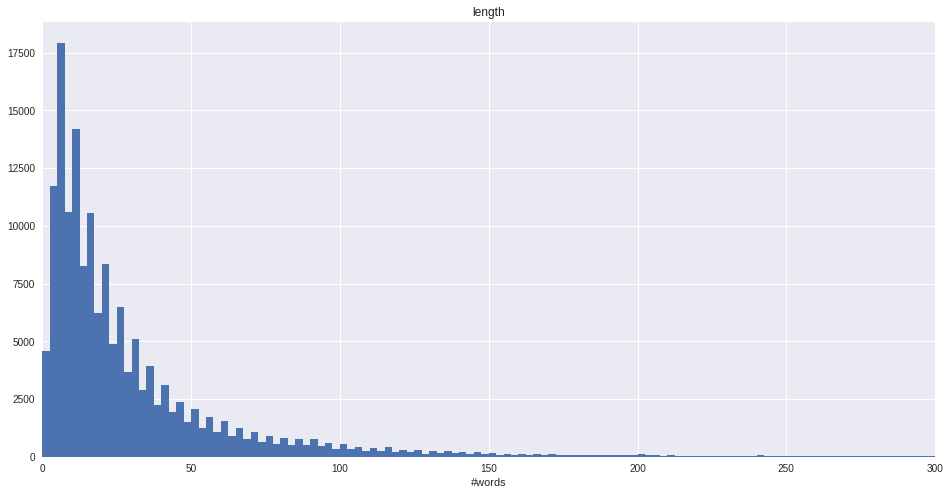

In [13]:
data.hist("length", bins=500, figsize=(16,8))
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

**Distribution of #words in test data**

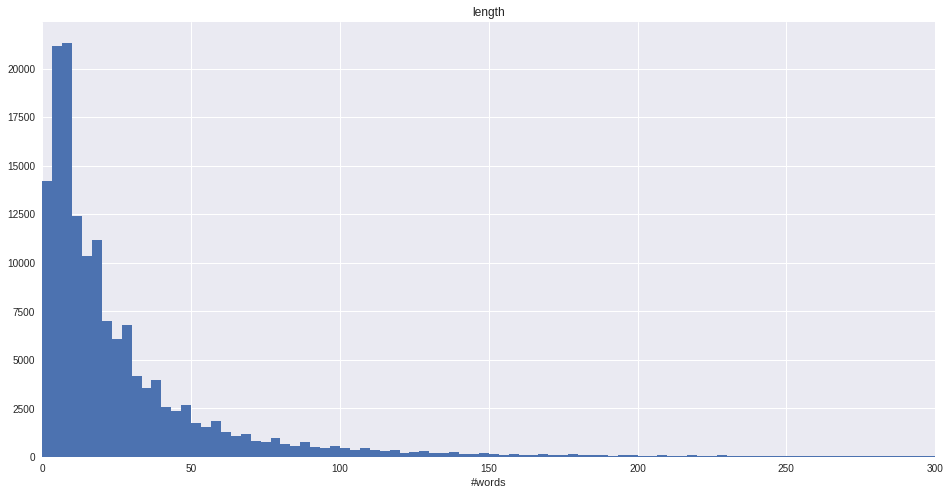

In [14]:
test_data.hist("length", bins=500, figsize=(16,8))
plt.xlabel("#words")
plt.xlim(0,300)
plt.show()

**Distribution of #words in all data**

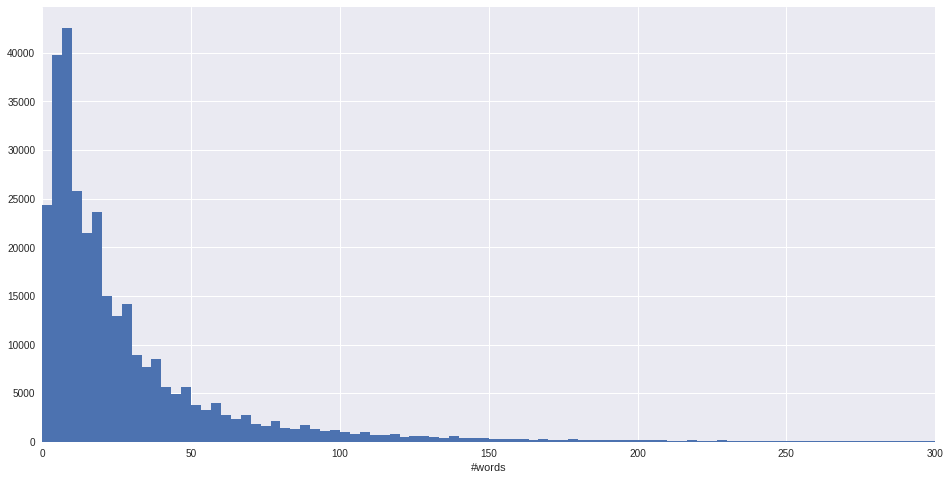

In [15]:
all_length = pd.concat([data['length'], test_data['length']])
all_length.hist(bins=500, figsize=(16,8))
plt.xlim(0,300)
plt.xlabel("#words")
plt.show()
del(all_length)

# Train validation split

**Extract the train, validation, and test data in numpy arrays**

In [0]:
comments = data["comment_text"].as_matrix()
sentiments = data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].as_matrix()
seq_length = data['length'].as_matrix()

train_indices = np.random.choice(len(seq_length), round(len(seq_length)*0.96), replace=False)
validation_indices = np.array(list(set(range(len(seq_length))) - set(train_indices)))

comments_train = comments[train_indices]
comments_validation = comments[validation_indices]
comments_test = test_data["comment_text"].as_matrix()

seq_length_train = seq_length[train_indices]
seq_length_validation = seq_length[validation_indices]
seq_length_test = test_data['length'].as_matrix()

sentiments_train = sentiments[train_indices]
sentiments_validation = sentiments[validation_indices]

test_id = test_data['id'].as_matrix()

In [17]:
print("shape of comments_train:",comments_train.shape)
print("shape of comments_validation:",comments_validation.shape)
print("shape of comments_test:",comments_test.shape)
print("shape of seq_length_train:",seq_length_train.shape)
print("shape of seq_length_validation:",seq_length_validation.shape)
print("shape of seq_length_test:",seq_length_test.shape)
print("shape of sentiments_train:",sentiments_train.shape)
print("shape of sentiments_test:",sentiments_validation.shape)
print("shape of test_id:",test_id.shape)

shape of comments_train: (153188,)
shape of comments_validation: (6383,)
shape of comments_test: (153164,)
shape of seq_length_train: (153188,)
shape of seq_length_validation: (6383,)
shape of seq_length_test: (153164,)
shape of sentiments_train: (153188, 6)
shape of sentiments_test: (6383, 6)
shape of test_id: (153164,)


In [0]:
del(train_indices, validation_indices, data, test_data, comments, sentiments, seq_length)

# Create Recurrent Neural Network (LSTM cell)

**A function to generate fixed length sequence**

In [0]:
def sequence_generator(comments, max_length, size):
    
    sentences = []
    for comment in comments.tolist():
        sentences.append(str(comment).split())
        
    sequences = []
    for sentence in sentences:
        if len(sentence)>0:
            if len(sentence)<max_length:
                sequence = model[sentence]
                tail = np.zeros((max_length - len(sentence), size))
                sequence = np.concatenate((sequence, tail))
            else:
                sequence = model[sentence[:max_length]]
        else:
            sequence = np.zeros((max_length, size))        
        sequences.append(sequence)
    sequences = np.array(sequences)
    
    return sequences

**Create onehotencode transformers for each different sentiments**

In [0]:
transformer0 = OneHotEncoder()
transformer0.fit(np.transpose([sentiments_train[:,0]]))
transformer1 = OneHotEncoder()
transformer1.fit(np.transpose([sentiments_train[:,1]]))
transformer2 = OneHotEncoder()
transformer2.fit(np.transpose([sentiments_train[:,2]]))
transformer3 = OneHotEncoder()
transformer3.fit(np.transpose([sentiments_train[:,3]]))
transformer4 = OneHotEncoder()
transformer4.fit(np.transpose([sentiments_train[:,4]]))
transformer5 = OneHotEncoder()
transformer5.fit(np.transpose([sentiments_train[:,5]]))
transformers = [transformer0, transformer1, transformer2, transformer3, transformer4, transformer5]

**Function to onehot the output of a specific sentiments**

In [0]:
def onehot_encode_sentiments(sentiments, sentiment_cls):
  
    encoded_data = transformers[sentiment_cls].transform(np.transpose([sentiments[:,sentiment_cls]]))
    
    return encoded_data.toarray()

**Function to generate batch data**

In [0]:
def generate_batch(indices, comments, seq_length, sentiments, sentiment_cls, max_length, size):
    
    comments_batch = comments[indices]
    seq_length_batch = seq_length[indices]
    sentiments_batch = sentiments[indices]
    sentiments_batch = onehot_encode_sentiments(sentiments_batch,sentiment_cls)
    
    sequences_batch = sequence_generator(comments_batch, max_length, size)
    
    return sequences_batch, seq_length_batch, sentiments_batch

**Function to create multilayered lstm cell**

In [0]:
def create_rnn(X, length, n_layers = 2, n_neurons = 128, name = "lstm", keep_prob = 0.75):

    with tf.variable_scope(name):
      
        lstm_cells = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons)
                      for layer in range(n_layers)]
        lstm_cells_drop = [tf.contrib.rnn.DropoutWrapper(cell, input_keep_prob=keep_prob)
                            for cell in lstm_cells]
        cells_across_gpu = [tf.contrib.rnn.DeviceWrapper("/device:GPU:0", cell) 
                            for cell in lstm_cells_drop]
        multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)

        outputs, states = tf.nn.dynamic_rnn(multi_cell, X, dtype=tf.float32, sequence_length=length)
        top_layer_h_state = states[-1][1]

    return top_layer_h_state

**Functions to create weights and biases for fully connected layer**

In [0]:
def create_weights(shape):
    '''a function to create weight tensor'''
    with tf.device("/device:CPU:0"):
      W = tf.Variable(tf.truncated_normal(shape, stddev=0.05))
    return W

def create_biases(size):
    '''a function to create bias tensor'''
    with tf.device("/device:CPU:0"):
      b = tf.Variable(tf.constant(0.05, shape=[size]))
    return b

**Function to create fully connected layer**

In [0]:
def create_fc_layer(input,          
                    num_inputs,    
                    num_outputs,
                    use_relu=False,
                    dropout = False, 
                    keep_prob = 0.2):
    
    '''a function for creating fully connected layer'''
    
    #Let's define trainable weights and biases.
    weights = create_weights(shape=[num_inputs, num_outputs])
    biases = create_biases(num_outputs)
    
    with tf.device("/device:GPU:0"):
      # matrix multiplication between input and weight matrix
      layer = tf.matmul(input, weights)

      # add the bias to the convolutional layer
      layer += biases

      # add relu activation if wanted
      if use_relu:
          layer = tf.nn.relu(layer)

      # if dropout is wanted add dropout
      if dropout:        
          layer = tf.nn.dropout(layer, keep_prob)

    # return layer
    return layer

**A function to create classification graph**

In [0]:
def create_graph(n_steps, n_inputs, n_outputs, 
                 n_layers = 2, n_neurons = 128, name = "lstm",
                 fc_layer_size1 = 64, learning_rate = (1e-2)*1.5):
  
    X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
    labels = tf.placeholder(tf.float32, [None, n_outputs])
    length = tf.placeholder(tf.int32, [None])
    keep_prob = tf.placeholder(tf.float32)

    rnn_output = create_rnn(X, length, name=name, keep_prob=keep_prob)

    layer_fc1 = create_fc_layer(input=rnn_output,
                              num_inputs=rnn_output.get_shape()[1].value,
                              num_outputs=fc_layer_size1,
                              use_relu=True,
                              dropout =True,
                              keep_prob = keep_prob)

    output = create_fc_layer(input=layer_fc1,
                              num_inputs=fc_layer_size1,
                              num_outputs=n_outputs,
                              use_relu=False,
                              dropout =False)

    with tf.device("/device:GPU:0"):
#         logits = tf.nn.sigmoid(output)
        logits = tf.nn.softmax(output)
        
        
    with tf.device("/device:GPU:0"):
#         loss = tf.reduce_mean(tf.losses.sigmoid_cross_entropy(multi_class_labels=labels, logits=output))
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output,labels=labels))
        
    roc = tf.metrics.auc(labels=labels, predictions=logits)
    

    with tf.device("/device:GPU:0"):
      # train step
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        
    return X, labels, length, keep_prob, logits, loss, roc, train_step

**Sequence parameters**

In [0]:
max_length = n_steps =200 
size = n_inputs = size
n_outputs = 2

**Test the generate batch function using a sequence** 

In [28]:
indices = np.random.choice(sentiments_train.shape[0], size=200)
sequences_batch, seq_length_batch, sentiments_batch = generate_batch(indices, comments_train, seq_length_train, sentiments_train, 0, max_length, size)
sentiments_batch.shape

(200, 2)

# Create & Train Six Models 

**Create 6 models for 6 different sentiments**

In [0]:
tf.reset_default_graph()
X0, labels0, length0, keep_prob0, logits0, loss0, roc0, train_step0 = create_graph(n_steps, n_inputs, n_outputs, name="lstm0", learning_rate = (1e-3))
X1, labels1, length1, keep_prob1, logits1, loss1, roc1, train_step1 = create_graph(n_steps, n_inputs, n_outputs, name="lstm1", learning_rate = (1e-3))
X2, labels2, length2, keep_prob2, logits2, loss2, roc2, train_step2 = create_graph(n_steps, n_inputs, n_outputs, name="lstm2", learning_rate = (1e-3))
X3, labels3, length3, keep_prob3, logits3, loss3, roc3, train_step3 = create_graph(n_steps, n_inputs, n_outputs, name="lstm3", learning_rate = (1e-4))
X4, labels4, length4, keep_prob4, logits4, loss4, roc4, train_step4 = create_graph(n_steps, n_inputs, n_outputs, name="lstm4", learning_rate = (1e-3))
X5, labels5, length5, keep_prob5, logits5, loss5, roc5, train_step5 = create_graph(n_steps, n_inputs, n_outputs, name="lstm5",learning_rate = (1e-4))

**Initialize variables**

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

### Function for training classifier

In [0]:
def train(X, labels, length, keep_prob, sentiment_cls, loss, roc, train_step, batch_size = 200, train_hours = 0.8, max_iter = 10000):

      # lists to store the train loss, validation loss, validation accuracy at each iteration
    train_loss = []
    valid_loss = []
    valid_roc = []

    # create a saver object
    saver = tf.train.Saver(max_to_keep=1)

    # variables to store the accuracy, loss, iteration of our best model
#   best_roc = -10
    best_loss = 1000
    best_iteration = None

    iteration = 0


    # feed dictionary for validation
    feed_dict_validation =  {X:sequence_generator(comments_validation, max_length, size),
                            labels:onehot_encode_sentiments(sentiments_validation, sentiment_cls),
                            length:seq_length_validation,
                            keep_prob: 1.0}

    t1 = time.time()

    # while minutes have not elapsed (to finish before the kernel is killed)
    while (time.time()-t1) < train_hours*60*60:

        # break if max iteration is reached
        if iteration >= max_iter:
            break

        # randomly choosing the indices of the batch 
        rand_index = np.random.choice(sentiments_train.shape[0], size=batch_size)

        # extract the batch data
        sequences_batch, seq_length_batch, sentiments_batch = \
        generate_batch(rand_index, comments_train, seq_length_train, sentiments_train,
                         sentiment_cls, max_length, size)

        # feed dictionary for batch
        feed_dict_batch =  {X:sequences_batch,
                              labels:sentiments_batch,
                              length:seq_length_batch,
                              keep_prob: 0.75}
        # feed dictionary for train
        feed_dict_train =  {X:sequences_batch,
                              labels:sentiments_batch,
                              length:seq_length_batch,
                              keep_prob: 1.0}        

        # execute optimization step
        sess.run(train_step, feed_dict=feed_dict_batch)

        # calculate temporary train loss and append it to the designated list
        temp_train_loss = loss.eval(session=sess, feed_dict=feed_dict_train)
        train_loss.append(temp_train_loss)
        # calculate temporary validation loss and append it to the designated list
        temp_validation_loss = loss.eval(session=sess, feed_dict=feed_dict_validation)
        valid_loss.append(temp_validation_loss)
        # calculate roc score
        temp_roc_score = sess.run(roc, feed_dict=feed_dict_validation)[1]
        valid_roc.append(temp_roc_score)

        # if valid loss is better than best recorded so far then
        # update the parameters of the best model and save the model
        if temp_validation_loss < best_loss:
            best_loss = temp_validation_loss
            best_iteration = iteration          
            saver.save(sess, './my-model'+str(sentiment_cls), global_step = best_iteration)

        # print metric info
        print("iterations:",iteration,
            "| train_loss:", temp_train_loss,
            "| validation_loss:", temp_validation_loss,
            "| Roc Score:", temp_roc_score,
            "| Time elapsed:",str(datetime.timedelta(seconds=time.time()-t1)))

        # increment iteration
        iteration = iteration+1
          
          
    return saver, best_iteration, iteration, train_loss, valid_loss, valid_roc

**Train models for sentiment 1**

In [32]:
sentiment_cls = 0
saver0, best_iteration0, iteration0, train_loss0, valid_loss0, valid_roc0 = train(X0, labels0, length0, keep_prob0, sentiment_cls, loss0, roc0, train_step0, max_iter = 1000)

iterations: 0 | train_loss: 0.64468515 | validation_loss: 0.6473168 | Roc Score: 0.9221473 | Time elapsed: 0:00:04.238329
iterations: 1 | train_loss: 0.6071718 | validation_loss: 0.6071438 | Roc Score: 0.9198345 | Time elapsed: 0:00:07.722080
iterations: 2 | train_loss: 0.554219 | validation_loss: 0.5620636 | Roc Score: 0.91928995 | Time elapsed: 0:00:11.222833
iterations: 3 | train_loss: 0.5015779 | validation_loss: 0.5096479 | Roc Score: 0.9188002 | Time elapsed: 0:00:14.705001
iterations: 4 | train_loss: 0.46315 | validation_loss: 0.45432895 | Roc Score: 0.91834533 | Time elapsed: 0:00:18.219806
iterations: 5 | train_loss: 0.40519845 | validation_loss: 0.40286577 | Roc Score: 0.91791236 | Time elapsed: 0:00:21.768322
iterations: 6 | train_loss: 0.3779847 | validation_loss: 0.36070177 | Roc Score: 0.9174952 | Time elapsed: 0:00:25.252607
iterations: 7 | train_loss: 0.31357715 | validation_loss: 0.33061016 | Roc Score: 0.91714865 | Time elapsed: 0:00:28.726857
iterations: 8 | train_lo

iterations: 78 | train_loss: 0.2323804 | validation_loss: 0.17508122 | Roc Score: 0.9620165 | Time elapsed: 0:04:17.599846
iterations: 79 | train_loss: 0.16496247 | validation_loss: 0.16975482 | Roc Score: 0.96230155 | Time elapsed: 0:04:21.181206
iterations: 80 | train_loss: 0.20087066 | validation_loss: 0.16558301 | Roc Score: 0.9625934 | Time elapsed: 0:04:24.640870
iterations: 81 | train_loss: 0.1441499 | validation_loss: 0.16368048 | Roc Score: 0.9628819 | Time elapsed: 0:04:28.165896
iterations: 82 | train_loss: 0.183877 | validation_loss: 0.16534697 | Roc Score: 0.9631548 | Time elapsed: 0:04:31.168762
iterations: 83 | train_loss: 0.22303371 | validation_loss: 0.17059377 | Roc Score: 0.96340084 | Time elapsed: 0:04:34.153631
iterations: 84 | train_loss: 0.20528628 | validation_loss: 0.17282343 | Roc Score: 0.96363205 | Time elapsed: 0:04:37.181767
iterations: 85 | train_loss: 0.15429497 | validation_loss: 0.16888723 | Roc Score: 0.96387196 | Time elapsed: 0:04:40.179398
iteratio

iterations: 156 | train_loss: 0.14065032 | validation_loss: 0.1338286 | Roc Score: 0.9750665 | Time elapsed: 0:08:29.370958
iterations: 157 | train_loss: 0.082122326 | validation_loss: 0.1316077 | Roc Score: 0.97516745 | Time elapsed: 0:08:32.952022
iterations: 158 | train_loss: 0.089338645 | validation_loss: 0.12972398 | Roc Score: 0.9752706 | Time elapsed: 0:08:36.490139
iterations: 159 | train_loss: 0.077417225 | validation_loss: 0.12873465 | Roc Score: 0.975373 | Time elapsed: 0:08:40.060501
iterations: 160 | train_loss: 0.16987363 | validation_loss: 0.12897858 | Roc Score: 0.9754733 | Time elapsed: 0:08:43.064825
iterations: 161 | train_loss: 0.1034071 | validation_loss: 0.12965472 | Roc Score: 0.9755708 | Time elapsed: 0:08:46.046352
iterations: 162 | train_loss: 0.10361754 | validation_loss: 0.12950727 | Roc Score: 0.9756675 | Time elapsed: 0:08:49.066052
iterations: 163 | train_loss: 0.076066464 | validation_loss: 0.1301398 | Roc Score: 0.9757614 | Time elapsed: 0:08:52.055243


iterations: 234 | train_loss: 0.052933857 | validation_loss: 0.13524975 | Roc Score: 0.98041844 | Time elapsed: 0:12:29.186703
iterations: 235 | train_loss: 0.058031067 | validation_loss: 0.138503 | Roc Score: 0.98044926 | Time elapsed: 0:12:32.153011
iterations: 236 | train_loss: 0.15784235 | validation_loss: 0.13771419 | Roc Score: 0.9804803 | Time elapsed: 0:12:35.169358
iterations: 237 | train_loss: 0.12011648 | validation_loss: 0.1333612 | Roc Score: 0.98051596 | Time elapsed: 0:12:38.159265
iterations: 238 | train_loss: 0.077742144 | validation_loss: 0.12782285 | Roc Score: 0.9805563 | Time elapsed: 0:12:41.177258
iterations: 239 | train_loss: 0.058504686 | validation_loss: 0.12434608 | Roc Score: 0.9805997 | Time elapsed: 0:12:44.142572
iterations: 240 | train_loss: 0.08402389 | validation_loss: 0.121190116 | Roc Score: 0.9806462 | Time elapsed: 0:12:47.116867
iterations: 241 | train_loss: 0.07988459 | validation_loss: 0.121996455 | Roc Score: 0.9806913 | Time elapsed: 0:12:50.1

iterations: 312 | train_loss: 0.06610263 | validation_loss: 0.11617875 | Roc Score: 0.983238 | Time elapsed: 0:16:27.542978
iterations: 313 | train_loss: 0.08178728 | validation_loss: 0.116368674 | Roc Score: 0.98326725 | Time elapsed: 0:16:30.524436
iterations: 314 | train_loss: 0.10182521 | validation_loss: 0.11648227 | Roc Score: 0.9832961 | Time elapsed: 0:16:33.523326
iterations: 315 | train_loss: 0.11092976 | validation_loss: 0.11658126 | Roc Score: 0.98332506 | Time elapsed: 0:16:36.486948
iterations: 316 | train_loss: 0.14964694 | validation_loss: 0.11652949 | Roc Score: 0.9833536 | Time elapsed: 0:16:39.507693
iterations: 317 | train_loss: 0.104316905 | validation_loss: 0.1164026 | Roc Score: 0.9833822 | Time elapsed: 0:16:42.475541
iterations: 318 | train_loss: 0.08554343 | validation_loss: 0.11644677 | Roc Score: 0.9834109 | Time elapsed: 0:16:45.464390
iterations: 319 | train_loss: 0.07466355 | validation_loss: 0.11645241 | Roc Score: 0.98343897 | Time elapsed: 0:16:48.5099

iterations: 390 | train_loss: 0.08549928 | validation_loss: 0.11761364 | Roc Score: 0.9849677 | Time elapsed: 0:20:22.151073
iterations: 391 | train_loss: 0.11186464 | validation_loss: 0.11766503 | Roc Score: 0.9849838 | Time elapsed: 0:20:25.128980
iterations: 392 | train_loss: 0.09791694 | validation_loss: 0.117551744 | Roc Score: 0.9849999 | Time elapsed: 0:20:28.111833
iterations: 393 | train_loss: 0.064740956 | validation_loss: 0.1178456 | Roc Score: 0.98501545 | Time elapsed: 0:20:31.081655
iterations: 394 | train_loss: 0.082005456 | validation_loss: 0.1180223 | Roc Score: 0.98503053 | Time elapsed: 0:20:34.077674
iterations: 395 | train_loss: 0.068074964 | validation_loss: 0.118204236 | Roc Score: 0.9850451 | Time elapsed: 0:20:37.068382
iterations: 396 | train_loss: 0.11915836 | validation_loss: 0.117882036 | Roc Score: 0.98505956 | Time elapsed: 0:20:40.087111
iterations: 397 | train_loss: 0.11740229 | validation_loss: 0.117257744 | Roc Score: 0.9850742 | Time elapsed: 0:20:43

iterations: 468 | train_loss: 0.09087542 | validation_loss: 0.116177835 | Roc Score: 0.9860305 | Time elapsed: 0:24:15.963360
iterations: 469 | train_loss: 0.20096722 | validation_loss: 0.11445881 | Roc Score: 0.9860422 | Time elapsed: 0:24:18.966330
iterations: 470 | train_loss: 0.07460888 | validation_loss: 0.113574825 | Roc Score: 0.9860551 | Time elapsed: 0:24:21.992527
iterations: 471 | train_loss: 0.12724063 | validation_loss: 0.112315714 | Roc Score: 0.98606867 | Time elapsed: 0:24:24.949762
iterations: 472 | train_loss: 0.07583833 | validation_loss: 0.11144327 | Roc Score: 0.9860822 | Time elapsed: 0:24:28.447075
iterations: 473 | train_loss: 0.066409275 | validation_loss: 0.11079265 | Roc Score: 0.986096 | Time elapsed: 0:24:31.986323
iterations: 474 | train_loss: 0.11660593 | validation_loss: 0.110257104 | Roc Score: 0.98611 | Time elapsed: 0:24:35.464667
iterations: 475 | train_loss: 0.10189881 | validation_loss: 0.10991686 | Roc Score: 0.98612404 | Time elapsed: 0:24:38.945

iterations: 546 | train_loss: 0.05513917 | validation_loss: 0.11580792 | Roc Score: 0.9868418 | Time elapsed: 0:28:12.180326
iterations: 547 | train_loss: 0.114064634 | validation_loss: 0.11702912 | Roc Score: 0.98684835 | Time elapsed: 0:28:15.146292
iterations: 548 | train_loss: 0.16843444 | validation_loss: 0.11609805 | Roc Score: 0.9868557 | Time elapsed: 0:28:18.172020
iterations: 549 | train_loss: 0.104151584 | validation_loss: 0.11443009 | Roc Score: 0.9868642 | Time elapsed: 0:28:21.163490
iterations: 550 | train_loss: 0.10705158 | validation_loss: 0.11285762 | Roc Score: 0.9868733 | Time elapsed: 0:28:24.137913
iterations: 551 | train_loss: 0.08518377 | validation_loss: 0.111884944 | Roc Score: 0.9868828 | Time elapsed: 0:28:27.150888
iterations: 552 | train_loss: 0.10750138 | validation_loss: 0.11140124 | Roc Score: 0.9868922 | Time elapsed: 0:28:30.122626
iterations: 553 | train_loss: 0.10055798 | validation_loss: 0.11124853 | Roc Score: 0.986902 | Time elapsed: 0:28:33.1835

iterations: 624 | train_loss: 0.13600858 | validation_loss: 0.10828584 | Roc Score: 0.9875007 | Time elapsed: 0:32:09.544641
iterations: 625 | train_loss: 0.109584026 | validation_loss: 0.1082849 | Roc Score: 0.98750895 | Time elapsed: 0:32:12.529265
iterations: 626 | train_loss: 0.09274286 | validation_loss: 0.10815728 | Roc Score: 0.9875173 | Time elapsed: 0:32:15.566352
iterations: 627 | train_loss: 0.075789995 | validation_loss: 0.10788405 | Roc Score: 0.9875257 | Time elapsed: 0:32:19.080129
iterations: 628 | train_loss: 0.085193194 | validation_loss: 0.1076676 | Roc Score: 0.98753417 | Time elapsed: 0:32:22.594643
iterations: 629 | train_loss: 0.124595344 | validation_loss: 0.10729983 | Roc Score: 0.98754275 | Time elapsed: 0:32:26.084118
iterations: 630 | train_loss: 0.089072526 | validation_loss: 0.10821291 | Roc Score: 0.9875508 | Time elapsed: 0:32:29.100469
iterations: 631 | train_loss: 0.08289702 | validation_loss: 0.10981918 | Roc Score: 0.9875581 | Time elapsed: 0:32:32.1

iterations: 702 | train_loss: 0.098296545 | validation_loss: 0.110172875 | Roc Score: 0.9880898 | Time elapsed: 0:36:10.018898
iterations: 703 | train_loss: 0.07552515 | validation_loss: 0.1104481 | Roc Score: 0.988095 | Time elapsed: 0:36:13.017754
iterations: 704 | train_loss: 0.072198145 | validation_loss: 0.11096663 | Roc Score: 0.98810005 | Time elapsed: 0:36:15.971152
iterations: 705 | train_loss: 0.079236925 | validation_loss: 0.1115448 | Roc Score: 0.9881051 | Time elapsed: 0:36:18.973285
iterations: 706 | train_loss: 0.123339765 | validation_loss: 0.112106815 | Roc Score: 0.98811024 | Time elapsed: 0:36:21.916007
iterations: 707 | train_loss: 0.107415706 | validation_loss: 0.11252603 | Roc Score: 0.9881151 | Time elapsed: 0:36:24.950202
iterations: 708 | train_loss: 0.15047327 | validation_loss: 0.11199282 | Roc Score: 0.9881204 | Time elapsed: 0:36:27.950068
iterations: 709 | train_loss: 0.036683563 | validation_loss: 0.11129029 | Roc Score: 0.98812574 | Time elapsed: 0:36:30

iterations: 780 | train_loss: 0.12972774 | validation_loss: 0.110500805 | Roc Score: 0.9885112 | Time elapsed: 0:40:03.889799
iterations: 781 | train_loss: 0.045968156 | validation_loss: 0.110881686 | Roc Score: 0.9885146 | Time elapsed: 0:40:06.935256
iterations: 782 | train_loss: 0.06715098 | validation_loss: 0.11142317 | Roc Score: 0.988518 | Time elapsed: 0:40:09.926275
iterations: 783 | train_loss: 0.08649449 | validation_loss: 0.110836476 | Roc Score: 0.98852164 | Time elapsed: 0:40:12.891677
iterations: 784 | train_loss: 0.11620575 | validation_loss: 0.109671675 | Roc Score: 0.98852557 | Time elapsed: 0:40:15.861273
iterations: 785 | train_loss: 0.07221735 | validation_loss: 0.1082175 | Roc Score: 0.98853004 | Time elapsed: 0:40:18.852202
iterations: 786 | train_loss: 0.07678177 | validation_loss: 0.10848715 | Roc Score: 0.9885349 | Time elapsed: 0:40:21.835883
iterations: 787 | train_loss: 0.1430114 | validation_loss: 0.11007931 | Roc Score: 0.9885397 | Time elapsed: 0:40:24.90

iterations: 858 | train_loss: 0.07565266 | validation_loss: 0.10629827 | Roc Score: 0.9888639 | Time elapsed: 0:43:56.527018
iterations: 859 | train_loss: 0.13555077 | validation_loss: 0.10625446 | Roc Score: 0.9888688 | Time elapsed: 0:43:59.507920
iterations: 860 | train_loss: 0.1204125 | validation_loss: 0.10644887 | Roc Score: 0.9888734 | Time elapsed: 0:44:02.493007
iterations: 861 | train_loss: 0.07298294 | validation_loss: 0.107013755 | Roc Score: 0.98887795 | Time elapsed: 0:44:05.469353
iterations: 862 | train_loss: 0.06407749 | validation_loss: 0.10779061 | Roc Score: 0.98888224 | Time elapsed: 0:44:08.471673
iterations: 863 | train_loss: 0.08518279 | validation_loss: 0.108043835 | Roc Score: 0.9888865 | Time elapsed: 0:44:11.503822
iterations: 864 | train_loss: 0.09535373 | validation_loss: 0.10772469 | Roc Score: 0.98889065 | Time elapsed: 0:44:14.500205
iterations: 865 | train_loss: 0.08829175 | validation_loss: 0.107388295 | Roc Score: 0.9888948 | Time elapsed: 0:44:17.47

iterations: 936 | train_loss: 0.06287599 | validation_loss: 0.10418678 | Roc Score: 0.98915136 | Time elapsed: 0:47:50.724606
iterations: 937 | train_loss: 0.07942155 | validation_loss: 0.10421346 | Roc Score: 0.98915553 | Time elapsed: 0:47:53.747574
iterations: 938 | train_loss: 0.10679285 | validation_loss: 0.10454711 | Roc Score: 0.98915935 | Time elapsed: 0:47:56.775746
iterations: 939 | train_loss: 0.12125871 | validation_loss: 0.10458596 | Roc Score: 0.98916334 | Time elapsed: 0:47:59.749467
iterations: 940 | train_loss: 0.07881214 | validation_loss: 0.10453268 | Roc Score: 0.9891674 | Time elapsed: 0:48:02.735528


**Train models for sentiment 2**

In [33]:
sentiment_cls = 1
saver1, best_iteration1, iteration1, train_loss1, valid_loss1, valid_roc1 = train(X1, labels1, length1, keep_prob1, sentiment_cls, loss1, roc1, train_step1, max_iter = 1000)

iterations: 0 | train_loss: 0.6281758 | validation_loss: 0.629711 | Roc Score: 0.9964198 | Time elapsed: 0:00:04.145324
iterations: 1 | train_loss: 0.5778888 | validation_loss: 0.5780259 | Roc Score: 0.9954436 | Time elapsed: 0:00:07.706490
iterations: 2 | train_loss: 0.51442355 | validation_loss: 0.5171663 | Roc Score: 0.99485207 | Time elapsed: 0:00:11.243049
iterations: 3 | train_loss: 0.4424015 | validation_loss: 0.4459208 | Roc Score: 0.99443686 | Time elapsed: 0:00:14.751832
iterations: 4 | train_loss: 0.35927024 | validation_loss: 0.37016708 | Roc Score: 0.99413955 | Time elapsed: 0:00:18.267124
iterations: 5 | train_loss: 0.31997466 | validation_loss: 0.29849738 | Roc Score: 0.9939102 | Time elapsed: 0:00:21.846022
iterations: 6 | train_loss: 0.24896835 | validation_loss: 0.2357961 | Roc Score: 0.9937246 | Time elapsed: 0:00:25.358730
iterations: 7 | train_loss: 0.21436393 | validation_loss: 0.18424541 | Roc Score: 0.99357086 | Time elapsed: 0:00:28.871690
iterations: 8 | train

iterations: 78 | train_loss: 0.018861964 | validation_loss: 0.048189197 | Roc Score: 0.9926265 | Time elapsed: 0:04:26.224021
iterations: 79 | train_loss: 0.045776475 | validation_loss: 0.047966756 | Roc Score: 0.9926497 | Time elapsed: 0:04:29.759105
iterations: 80 | train_loss: 0.009881888 | validation_loss: 0.047765512 | Roc Score: 0.9926653 | Time elapsed: 0:04:33.268968
iterations: 81 | train_loss: 0.03397184 | validation_loss: 0.04759548 | Roc Score: 0.9926779 | Time elapsed: 0:04:36.807686
iterations: 82 | train_loss: 0.062328745 | validation_loss: 0.047447678 | Roc Score: 0.99268895 | Time elapsed: 0:04:40.378039
iterations: 83 | train_loss: 0.033493925 | validation_loss: 0.047339827 | Roc Score: 0.99269986 | Time elapsed: 0:04:43.944154
iterations: 84 | train_loss: 0.05555619 | validation_loss: 0.04725084 | Roc Score: 0.9927254 | Time elapsed: 0:04:47.496654
iterations: 85 | train_loss: 0.07979096 | validation_loss: 0.04712415 | Roc Score: 0.99275684 | Time elapsed: 0:04:51.02

iterations: 156 | train_loss: 0.016573172 | validation_loss: 0.026240965 | Roc Score: 0.995714 | Time elapsed: 0:09:00.437127
iterations: 157 | train_loss: 0.04253491 | validation_loss: 0.026559073 | Roc Score: 0.99574345 | Time elapsed: 0:09:03.387861
iterations: 158 | train_loss: 0.027418708 | validation_loss: 0.027034165 | Roc Score: 0.9957732 | Time elapsed: 0:09:06.402183
iterations: 159 | train_loss: 0.023265917 | validation_loss: 0.027178584 | Roc Score: 0.9958033 | Time elapsed: 0:09:09.376481
iterations: 160 | train_loss: 0.06767518 | validation_loss: 0.026926123 | Roc Score: 0.9958326 | Time elapsed: 0:09:12.370955
iterations: 161 | train_loss: 0.016068768 | validation_loss: 0.026508927 | Roc Score: 0.9958608 | Time elapsed: 0:09:15.305612
iterations: 162 | train_loss: 0.030746855 | validation_loss: 0.026346648 | Roc Score: 0.9958877 | Time elapsed: 0:09:18.269820
iterations: 163 | train_loss: 0.12406755 | validation_loss: 0.027177194 | Roc Score: 0.99591523 | Time elapsed: 0

iterations: 234 | train_loss: 0.014505705 | validation_loss: 0.024005027 | Roc Score: 0.9971894 | Time elapsed: 0:13:05.502749
iterations: 235 | train_loss: 0.022649353 | validation_loss: 0.023905504 | Roc Score: 0.99720013 | Time elapsed: 0:13:08.493394
iterations: 236 | train_loss: 0.026396008 | validation_loss: 0.024095908 | Roc Score: 0.99721074 | Time elapsed: 0:13:11.448965
iterations: 237 | train_loss: 0.046418056 | validation_loss: 0.024101175 | Roc Score: 0.997221 | Time elapsed: 0:13:14.480789
iterations: 238 | train_loss: 0.03163189 | validation_loss: 0.023975044 | Roc Score: 0.9972312 | Time elapsed: 0:13:17.467138
iterations: 239 | train_loss: 0.015341364 | validation_loss: 0.023959506 | Roc Score: 0.997241 | Time elapsed: 0:13:20.443650
iterations: 240 | train_loss: 0.017613735 | validation_loss: 0.02390979 | Roc Score: 0.99725044 | Time elapsed: 0:13:23.458006
iterations: 241 | train_loss: 0.010515026 | validation_loss: 0.023977937 | Roc Score: 0.99725944 | Time elapsed:

iterations: 312 | train_loss: 0.00912943 | validation_loss: 0.021164458 | Roc Score: 0.997869 | Time elapsed: 0:17:05.261811
iterations: 313 | train_loss: 0.028915811 | validation_loss: 0.021457778 | Roc Score: 0.9978764 | Time elapsed: 0:17:08.268435
iterations: 314 | train_loss: 0.037730385 | validation_loss: 0.02212765 | Roc Score: 0.99788356 | Time elapsed: 0:17:11.245195
iterations: 315 | train_loss: 0.02735759 | validation_loss: 0.02300651 | Roc Score: 0.99789083 | Time elapsed: 0:17:14.272115
iterations: 316 | train_loss: 0.025178885 | validation_loss: 0.023646796 | Roc Score: 0.9978979 | Time elapsed: 0:17:17.261187
iterations: 317 | train_loss: 0.0108412625 | validation_loss: 0.02398668 | Roc Score: 0.99790454 | Time elapsed: 0:17:20.310695
iterations: 318 | train_loss: 0.04698784 | validation_loss: 0.024065522 | Roc Score: 0.99791104 | Time elapsed: 0:17:23.314070
iterations: 319 | train_loss: 0.020503523 | validation_loss: 0.023784414 | Roc Score: 0.99791765 | Time elapsed: 

iterations: 390 | train_loss: 0.017087644 | validation_loss: 0.020289704 | Roc Score: 0.9982909 | Time elapsed: 0:21:02.972204
iterations: 391 | train_loss: 0.013629718 | validation_loss: 0.020284828 | Roc Score: 0.99829507 | Time elapsed: 0:21:05.949710
iterations: 392 | train_loss: 0.023526972 | validation_loss: 0.02028027 | Roc Score: 0.99829924 | Time elapsed: 0:21:08.996685
iterations: 393 | train_loss: 0.042453777 | validation_loss: 0.020308303 | Roc Score: 0.9983035 | Time elapsed: 0:21:11.955879
iterations: 394 | train_loss: 0.01519188 | validation_loss: 0.020329399 | Roc Score: 0.9983075 | Time elapsed: 0:21:14.926871
iterations: 395 | train_loss: 0.0030396325 | validation_loss: 0.020338437 | Roc Score: 0.99831176 | Time elapsed: 0:21:17.890316
iterations: 396 | train_loss: 0.036923543 | validation_loss: 0.020358596 | Roc Score: 0.9983157 | Time elapsed: 0:21:20.924494
iterations: 397 | train_loss: 0.004039464 | validation_loss: 0.020377047 | Roc Score: 0.9983198 | Time elapse

iterations: 468 | train_loss: 0.014849236 | validation_loss: 0.020701017 | Roc Score: 0.99856293 | Time elapsed: 0:24:58.065900
iterations: 469 | train_loss: 0.023346405 | validation_loss: 0.02072102 | Roc Score: 0.998566 | Time elapsed: 0:25:01.107437
iterations: 470 | train_loss: 0.013373877 | validation_loss: 0.02070227 | Roc Score: 0.998569 | Time elapsed: 0:25:04.065063
iterations: 471 | train_loss: 0.0073224735 | validation_loss: 0.020615019 | Roc Score: 0.9985721 | Time elapsed: 0:25:07.124503
iterations: 472 | train_loss: 0.017647605 | validation_loss: 0.020488119 | Roc Score: 0.9985749 | Time elapsed: 0:25:10.094592
iterations: 473 | train_loss: 0.026497439 | validation_loss: 0.020372447 | Roc Score: 0.9985775 | Time elapsed: 0:25:13.124004
iterations: 474 | train_loss: 0.009975061 | validation_loss: 0.020288562 | Roc Score: 0.9985801 | Time elapsed: 0:25:16.094937
iterations: 475 | train_loss: 0.04405304 | validation_loss: 0.020260265 | Roc Score: 0.9985829 | Time elapsed: 0:

iterations: 546 | train_loss: 0.023002358 | validation_loss: 0.020897508 | Roc Score: 0.99873346 | Time elapsed: 0:28:51.881356
iterations: 547 | train_loss: 0.010414424 | validation_loss: 0.020927297 | Roc Score: 0.9987354 | Time elapsed: 0:28:54.940946
iterations: 548 | train_loss: 0.021030448 | validation_loss: 0.020954005 | Roc Score: 0.9987373 | Time elapsed: 0:28:57.949014
iterations: 549 | train_loss: 0.021221483 | validation_loss: 0.020958332 | Roc Score: 0.9987391 | Time elapsed: 0:29:00.927274
iterations: 550 | train_loss: 0.0042136293 | validation_loss: 0.020962983 | Roc Score: 0.9987411 | Time elapsed: 0:29:03.879707
iterations: 551 | train_loss: 0.014660008 | validation_loss: 0.020971509 | Roc Score: 0.9987428 | Time elapsed: 0:29:06.935182
iterations: 552 | train_loss: 0.018554341 | validation_loss: 0.020980397 | Roc Score: 0.9987449 | Time elapsed: 0:29:09.998980
iterations: 553 | train_loss: 0.0068922876 | validation_loss: 0.021008391 | Roc Score: 0.99874645 | Time elap

iterations: 624 | train_loss: 0.026393197 | validation_loss: 0.020194843 | Roc Score: 0.99886763 | Time elapsed: 0:32:45.565871
iterations: 625 | train_loss: 0.0018300281 | validation_loss: 0.020228863 | Roc Score: 0.9988691 | Time elapsed: 0:32:48.591002
iterations: 626 | train_loss: 0.020804277 | validation_loss: 0.02024368 | Roc Score: 0.99887043 | Time elapsed: 0:32:51.590595
iterations: 627 | train_loss: 0.029782668 | validation_loss: 0.02027145 | Roc Score: 0.9988722 | Time elapsed: 0:32:54.627438
iterations: 628 | train_loss: 0.006172179 | validation_loss: 0.020301323 | Roc Score: 0.99887353 | Time elapsed: 0:32:57.588576
iterations: 629 | train_loss: 0.024912717 | validation_loss: 0.020317703 | Roc Score: 0.99887526 | Time elapsed: 0:33:00.575868
iterations: 630 | train_loss: 0.018385557 | validation_loss: 0.020314794 | Roc Score: 0.99887675 | Time elapsed: 0:33:03.585237
iterations: 631 | train_loss: 0.038799614 | validation_loss: 0.020323537 | Roc Score: 0.99887824 | Time ela

iterations: 702 | train_loss: 0.045069814 | validation_loss: 0.020449521 | Roc Score: 0.99897027 | Time elapsed: 0:36:41.661129
iterations: 703 | train_loss: 0.029636724 | validation_loss: 0.020428307 | Roc Score: 0.99897146 | Time elapsed: 0:36:44.657300
iterations: 704 | train_loss: 0.035547923 | validation_loss: 0.020541392 | Roc Score: 0.9989725 | Time elapsed: 0:36:47.632449
iterations: 705 | train_loss: 0.011383921 | validation_loss: 0.020718714 | Roc Score: 0.9989737 | Time elapsed: 0:36:50.593103
iterations: 706 | train_loss: 0.009020856 | validation_loss: 0.020888835 | Roc Score: 0.998975 | Time elapsed: 0:36:53.582747
iterations: 707 | train_loss: 0.022252277 | validation_loss: 0.020987758 | Roc Score: 0.99897635 | Time elapsed: 0:36:56.572139
iterations: 708 | train_loss: 0.0062402203 | validation_loss: 0.021002486 | Roc Score: 0.99897766 | Time elapsed: 0:36:59.514782
iterations: 709 | train_loss: 0.015647274 | validation_loss: 0.02092814 | Roc Score: 0.99897873 | Time elap

iterations: 780 | train_loss: 0.021283519 | validation_loss: 0.022146475 | Roc Score: 0.9990502 | Time elapsed: 0:40:35.427975
iterations: 781 | train_loss: 0.016695252 | validation_loss: 0.021731094 | Roc Score: 0.99905115 | Time elapsed: 0:40:38.431535
iterations: 782 | train_loss: 0.02429807 | validation_loss: 0.021356095 | Roc Score: 0.9990523 | Time elapsed: 0:40:41.385277
iterations: 783 | train_loss: 0.035293117 | validation_loss: 0.021071622 | Roc Score: 0.99905336 | Time elapsed: 0:40:44.405118
iterations: 784 | train_loss: 0.0317376 | validation_loss: 0.02100319 | Roc Score: 0.9990543 | Time elapsed: 0:40:47.358010
iterations: 785 | train_loss: 0.010309654 | validation_loss: 0.020824099 | Roc Score: 0.99905545 | Time elapsed: 0:40:50.237200
iterations: 786 | train_loss: 0.012807521 | validation_loss: 0.020588594 | Roc Score: 0.9990563 | Time elapsed: 0:40:53.219494
iterations: 787 | train_loss: 0.0006827911 | validation_loss: 0.020394893 | Roc Score: 0.9990573 | Time elapsed:

iterations: 858 | train_loss: 0.017571814 | validation_loss: 0.020493029 | Roc Score: 0.9991147 | Time elapsed: 0:44:26.958049
iterations: 859 | train_loss: 0.015383872 | validation_loss: 0.020468844 | Roc Score: 0.99911565 | Time elapsed: 0:44:29.970145
iterations: 860 | train_loss: 0.022918647 | validation_loss: 0.020421017 | Roc Score: 0.9991163 | Time elapsed: 0:44:32.961045
iterations: 861 | train_loss: 0.0130119035 | validation_loss: 0.020374699 | Roc Score: 0.99911714 | Time elapsed: 0:44:35.937750
iterations: 862 | train_loss: 0.008120534 | validation_loss: 0.020362543 | Roc Score: 0.99911803 | Time elapsed: 0:44:38.916374
iterations: 863 | train_loss: 0.0023627933 | validation_loss: 0.020388458 | Roc Score: 0.99911886 | Time elapsed: 0:44:41.894325
iterations: 864 | train_loss: 0.03414027 | validation_loss: 0.020432917 | Roc Score: 0.99911946 | Time elapsed: 0:44:44.886981
iterations: 865 | train_loss: 0.032650482 | validation_loss: 0.02046769 | Roc Score: 0.99912006 | Time el

**Train models for sentiment 3**

In [34]:
sentiment_cls = 2
saver2, best_iteration2, iteration2, train_loss2, valid_loss2, valid_roc2 = train(X2, labels2, length2, keep_prob2, sentiment_cls, loss2, roc2, train_step2, max_iter = 1000)

iterations: 0 | train_loss: 0.6464336 | validation_loss: 0.6499072 | Roc Score: 0.9524518 | Time elapsed: 0:00:04.080727
iterations: 1 | train_loss: 0.61467916 | validation_loss: 0.6112401 | Roc Score: 0.9551325 | Time elapsed: 0:00:07.653651
iterations: 2 | train_loss: 0.56385654 | validation_loss: 0.5654904 | Roc Score: 0.9561377 | Time elapsed: 0:00:11.037037
iterations: 3 | train_loss: 0.5216903 | validation_loss: 0.50930536 | Roc Score: 0.95653194 | Time elapsed: 0:00:14.524153
iterations: 4 | train_loss: 0.4565114 | validation_loss: 0.44518366 | Roc Score: 0.95656306 | Time elapsed: 0:00:18.008198
iterations: 5 | train_loss: 0.3436801 | validation_loss: 0.38033682 | Roc Score: 0.9564457 | Time elapsed: 0:00:21.491372
iterations: 6 | train_loss: 0.31691787 | validation_loss: 0.32094252 | Roc Score: 0.95624644 | Time elapsed: 0:00:25.048800
iterations: 7 | train_loss: 0.27306038 | validation_loss: 0.27261588 | Roc Score: 0.9560351 | Time elapsed: 0:00:28.594550
iterations: 8 | trai

iterations: 78 | train_loss: 0.1029842 | validation_loss: 0.103891 | Roc Score: 0.9814246 | Time elapsed: 0:04:28.223386
iterations: 79 | train_loss: 0.08687221 | validation_loss: 0.10184459 | Roc Score: 0.9816152 | Time elapsed: 0:04:31.815242
iterations: 80 | train_loss: 0.10105535 | validation_loss: 0.10051535 | Roc Score: 0.9818057 | Time elapsed: 0:04:35.368558
iterations: 81 | train_loss: 0.053915285 | validation_loss: 0.100477636 | Roc Score: 0.9819861 | Time elapsed: 0:04:38.986991
iterations: 82 | train_loss: 0.09196581 | validation_loss: 0.10207085 | Roc Score: 0.98215103 | Time elapsed: 0:04:42.053046
iterations: 83 | train_loss: 0.11293635 | validation_loss: 0.10480391 | Roc Score: 0.9822979 | Time elapsed: 0:04:45.099433
iterations: 84 | train_loss: 0.09311803 | validation_loss: 0.108609974 | Roc Score: 0.98242384 | Time elapsed: 0:04:48.080680
iterations: 85 | train_loss: 0.1328549 | validation_loss: 0.1110467 | Roc Score: 0.9825367 | Time elapsed: 0:04:51.088679
iteratio

iterations: 156 | train_loss: 0.050427694 | validation_loss: 0.06877657 | Roc Score: 0.9891546 | Time elapsed: 0:08:44.150637
iterations: 157 | train_loss: 0.03385083 | validation_loss: 0.07025764 | Roc Score: 0.98920745 | Time elapsed: 0:08:47.162392
iterations: 158 | train_loss: 0.063597746 | validation_loss: 0.07256025 | Roc Score: 0.98925614 | Time elapsed: 0:08:50.192807
iterations: 159 | train_loss: 0.0916687 | validation_loss: 0.07445151 | Roc Score: 0.98930216 | Time elapsed: 0:08:53.160676
iterations: 160 | train_loss: 0.08108756 | validation_loss: 0.074672945 | Roc Score: 0.98934674 | Time elapsed: 0:08:56.142561
iterations: 161 | train_loss: 0.13372442 | validation_loss: 0.07147371 | Roc Score: 0.9893952 | Time elapsed: 0:08:59.173922
iterations: 162 | train_loss: 0.15173623 | validation_loss: 0.067682356 | Roc Score: 0.9894508 | Time elapsed: 0:09:02.706264
iterations: 163 | train_loss: 0.06959542 | validation_loss: 0.06719705 | Roc Score: 0.98950696 | Time elapsed: 0:09:06

iterations: 234 | train_loss: 0.06251074 | validation_loss: 0.06265688 | Roc Score: 0.9918884 | Time elapsed: 0:12:43.671833
iterations: 235 | train_loss: 0.026907103 | validation_loss: 0.06216696 | Roc Score: 0.991916 | Time elapsed: 0:12:46.701830
iterations: 236 | train_loss: 0.0371612 | validation_loss: 0.061786365 | Roc Score: 0.9919434 | Time elapsed: 0:12:49.709743
iterations: 237 | train_loss: 0.06640441 | validation_loss: 0.061491165 | Roc Score: 0.9919704 | Time elapsed: 0:12:52.761440
iterations: 238 | train_loss: 0.07563866 | validation_loss: 0.061452582 | Roc Score: 0.9919971 | Time elapsed: 0:12:55.774322
iterations: 239 | train_loss: 0.04380514 | validation_loss: 0.061450742 | Roc Score: 0.99202406 | Time elapsed: 0:12:58.735374
iterations: 240 | train_loss: 0.05860657 | validation_loss: 0.061178822 | Roc Score: 0.99205047 | Time elapsed: 0:13:02.281076
iterations: 241 | train_loss: 0.05645366 | validation_loss: 0.06077685 | Roc Score: 0.9920771 | Time elapsed: 0:13:05.8

iterations: 312 | train_loss: 0.06397786 | validation_loss: 0.061476104 | Roc Score: 0.99339944 | Time elapsed: 0:16:42.879211
iterations: 313 | train_loss: 0.08163792 | validation_loss: 0.060276624 | Roc Score: 0.9934135 | Time elapsed: 0:16:45.859626
iterations: 314 | train_loss: 0.032311197 | validation_loss: 0.059392616 | Roc Score: 0.99342793 | Time elapsed: 0:16:49.376750
iterations: 315 | train_loss: 0.043285474 | validation_loss: 0.058767244 | Roc Score: 0.9934427 | Time elapsed: 0:16:52.928067
iterations: 316 | train_loss: 0.13457286 | validation_loss: 0.05839327 | Roc Score: 0.99345815 | Time elapsed: 0:16:56.500532
iterations: 317 | train_loss: 0.058560066 | validation_loss: 0.05968123 | Roc Score: 0.99347293 | Time elapsed: 0:16:59.501034
iterations: 318 | train_loss: 0.06964737 | validation_loss: 0.062035788 | Roc Score: 0.9934868 | Time elapsed: 0:17:02.494908
iterations: 319 | train_loss: 0.05505233 | validation_loss: 0.06495202 | Roc Score: 0.99349976 | Time elapsed: 0:

iterations: 390 | train_loss: 0.049951635 | validation_loss: 0.059655216 | Roc Score: 0.99419755 | Time elapsed: 0:20:38.947439
iterations: 391 | train_loss: 0.074683025 | validation_loss: 0.058815964 | Roc Score: 0.9942064 | Time elapsed: 0:20:41.983930
iterations: 392 | train_loss: 0.080128334 | validation_loss: 0.05821316 | Roc Score: 0.9942158 | Time elapsed: 0:20:44.959979
iterations: 393 | train_loss: 0.034394633 | validation_loss: 0.05761702 | Roc Score: 0.9942249 | Time elapsed: 0:20:47.931501
iterations: 394 | train_loss: 0.06082818 | validation_loss: 0.057303023 | Roc Score: 0.9942347 | Time elapsed: 0:20:50.893897
iterations: 395 | train_loss: 0.059863385 | validation_loss: 0.05723078 | Roc Score: 0.99424446 | Time elapsed: 0:20:53.905461
iterations: 396 | train_loss: 0.0829431 | validation_loss: 0.057412338 | Roc Score: 0.99425435 | Time elapsed: 0:20:56.893320
iterations: 397 | train_loss: 0.045676474 | validation_loss: 0.05757607 | Roc Score: 0.9942641 | Time elapsed: 0:2

iterations: 468 | train_loss: 0.10322488 | validation_loss: 0.060610756 | Roc Score: 0.9948091 | Time elapsed: 0:24:35.085693
iterations: 469 | train_loss: 0.075132355 | validation_loss: 0.060917206 | Roc Score: 0.9948145 | Time elapsed: 0:24:38.118197
iterations: 470 | train_loss: 0.0364445 | validation_loss: 0.060024522 | Roc Score: 0.9948201 | Time elapsed: 0:24:41.125063
iterations: 471 | train_loss: 0.05382145 | validation_loss: 0.05856149 | Roc Score: 0.99482614 | Time elapsed: 0:24:44.158317
iterations: 472 | train_loss: 0.041062895 | validation_loss: 0.056902677 | Roc Score: 0.9948324 | Time elapsed: 0:24:47.160225
iterations: 473 | train_loss: 0.079305485 | validation_loss: 0.055426642 | Roc Score: 0.994839 | Time elapsed: 0:24:50.124637
iterations: 474 | train_loss: 0.047395676 | validation_loss: 0.054422993 | Roc Score: 0.9948458 | Time elapsed: 0:24:53.623158
iterations: 475 | train_loss: 0.050389495 | validation_loss: 0.053995114 | Roc Score: 0.9948525 | Time elapsed: 0:24

iterations: 546 | train_loss: 0.13184363 | validation_loss: 0.053733885 | Roc Score: 0.99522847 | Time elapsed: 0:28:32.026351
iterations: 547 | train_loss: 0.040093496 | validation_loss: 0.053713396 | Roc Score: 0.99523336 | Time elapsed: 0:28:34.996989
iterations: 548 | train_loss: 0.039330814 | validation_loss: 0.053775206 | Roc Score: 0.99523836 | Time elapsed: 0:28:37.996667
iterations: 549 | train_loss: 0.059929565 | validation_loss: 0.05391744 | Roc Score: 0.9952435 | Time elapsed: 0:28:40.960381
iterations: 550 | train_loss: 0.07386673 | validation_loss: 0.0540816 | Roc Score: 0.9952484 | Time elapsed: 0:28:43.945555
iterations: 551 | train_loss: 0.06479909 | validation_loss: 0.054127894 | Roc Score: 0.99525344 | Time elapsed: 0:28:46.979992
iterations: 552 | train_loss: 0.09722133 | validation_loss: 0.054014448 | Roc Score: 0.9952584 | Time elapsed: 0:28:49.967077
iterations: 553 | train_loss: 0.072187856 | validation_loss: 0.053957287 | Roc Score: 0.9952634 | Time elapsed: 0:

iterations: 624 | train_loss: 0.03940941 | validation_loss: 0.05543438 | Roc Score: 0.99553746 | Time elapsed: 0:32:26.568040
iterations: 625 | train_loss: 0.08676371 | validation_loss: 0.05500755 | Roc Score: 0.9955408 | Time elapsed: 0:32:29.567819
iterations: 626 | train_loss: 0.044129916 | validation_loss: 0.054153655 | Roc Score: 0.9955445 | Time elapsed: 0:32:32.542070
iterations: 627 | train_loss: 0.06485646 | validation_loss: 0.053707045 | Roc Score: 0.99554807 | Time elapsed: 0:32:35.593627
iterations: 628 | train_loss: 0.062426597 | validation_loss: 0.05329479 | Roc Score: 0.9955516 | Time elapsed: 0:32:39.164322
iterations: 629 | train_loss: 0.07327899 | validation_loss: 0.053706005 | Roc Score: 0.9955548 | Time elapsed: 0:32:42.176665
iterations: 630 | train_loss: 0.039570868 | validation_loss: 0.054834172 | Roc Score: 0.9955582 | Time elapsed: 0:32:45.188889
iterations: 631 | train_loss: 0.083996065 | validation_loss: 0.056376994 | Roc Score: 0.9955608 | Time elapsed: 0:32

iterations: 702 | train_loss: 0.05966182 | validation_loss: 0.052614223 | Roc Score: 0.99575746 | Time elapsed: 0:36:24.629573
iterations: 703 | train_loss: 0.040253486 | validation_loss: 0.05244392 | Roc Score: 0.99576044 | Time elapsed: 0:36:27.608398
iterations: 704 | train_loss: 0.044012114 | validation_loss: 0.052519437 | Roc Score: 0.99576324 | Time elapsed: 0:36:30.620296
iterations: 705 | train_loss: 0.028938226 | validation_loss: 0.052260783 | Roc Score: 0.9957661 | Time elapsed: 0:36:33.589172
iterations: 706 | train_loss: 0.049896713 | validation_loss: 0.052140202 | Roc Score: 0.9957688 | Time elapsed: 0:36:36.570789
iterations: 707 | train_loss: 0.04386704 | validation_loss: 0.051966116 | Roc Score: 0.99577165 | Time elapsed: 0:36:39.552673
iterations: 708 | train_loss: 0.038074628 | validation_loss: 0.05184608 | Roc Score: 0.9957745 | Time elapsed: 0:36:42.489556
iterations: 709 | train_loss: 0.024845844 | validation_loss: 0.051614422 | Roc Score: 0.99577737 | Time elapsed

iterations: 780 | train_loss: 0.028961077 | validation_loss: 0.050770987 | Roc Score: 0.99597085 | Time elapsed: 0:40:22.307611
iterations: 781 | train_loss: 0.038308874 | validation_loss: 0.050595894 | Roc Score: 0.99597365 | Time elapsed: 0:40:25.916206
iterations: 782 | train_loss: 0.05541521 | validation_loss: 0.05098042 | Roc Score: 0.99597603 | Time elapsed: 0:40:28.895802
iterations: 783 | train_loss: 0.08603007 | validation_loss: 0.051996894 | Roc Score: 0.9959781 | Time elapsed: 0:40:31.902088
iterations: 784 | train_loss: 0.030702716 | validation_loss: 0.052428223 | Roc Score: 0.99598 | Time elapsed: 0:40:34.883196
iterations: 785 | train_loss: 0.071572095 | validation_loss: 0.05271872 | Roc Score: 0.99598205 | Time elapsed: 0:40:37.879770
iterations: 786 | train_loss: 0.05280663 | validation_loss: 0.05320596 | Roc Score: 0.9959838 | Time elapsed: 0:40:40.888736
iterations: 787 | train_loss: 0.07738652 | validation_loss: 0.05372096 | Roc Score: 0.9959855 | Time elapsed: 0:40:

iterations: 858 | train_loss: 0.0223169 | validation_loss: 0.052556917 | Roc Score: 0.9961258 | Time elapsed: 0:44:16.308004
iterations: 859 | train_loss: 0.06656623 | validation_loss: 0.05310204 | Roc Score: 0.996127 | Time elapsed: 0:44:19.300921
iterations: 860 | train_loss: 0.036944374 | validation_loss: 0.054058727 | Roc Score: 0.996128 | Time elapsed: 0:44:22.220572
iterations: 861 | train_loss: 0.08085553 | validation_loss: 0.055233914 | Roc Score: 0.996129 | Time elapsed: 0:44:25.219758
iterations: 862 | train_loss: 0.078073844 | validation_loss: 0.05565974 | Roc Score: 0.99612945 | Time elapsed: 0:44:28.207662
iterations: 863 | train_loss: 0.03456612 | validation_loss: 0.056126345 | Roc Score: 0.9961301 | Time elapsed: 0:44:31.239563
iterations: 864 | train_loss: 0.030426519 | validation_loss: 0.056244083 | Roc Score: 0.9961305 | Time elapsed: 0:44:34.189524
iterations: 865 | train_loss: 0.074512556 | validation_loss: 0.055249598 | Roc Score: 0.99613166 | Time elapsed: 0:44:37

**Train models for sentiment 4**

In [35]:
sentiment_cls = 3
saver3, best_iteration3, iteration3, train_loss3, valid_loss3, valid_roc3 = train(X3, labels3, length3, keep_prob3, sentiment_cls, loss3, roc3, train_step3, max_iter = 1000)

iterations: 0 | train_loss: 0.68323815 | validation_loss: 0.68335885 | Roc Score: 0.9074672 | Time elapsed: 0:00:04.024596
iterations: 1 | train_loss: 0.6773136 | validation_loss: 0.67823374 | Roc Score: 0.9395648 | Time elapsed: 0:00:07.560821
iterations: 2 | train_loss: 0.67501825 | validation_loss: 0.67320323 | Roc Score: 0.9577325 | Time elapsed: 0:00:11.056477
iterations: 3 | train_loss: 0.6685139 | validation_loss: 0.6682571 | Roc Score: 0.9687636 | Time elapsed: 0:00:14.603097
iterations: 4 | train_loss: 0.66351944 | validation_loss: 0.6633686 | Roc Score: 0.9758608 | Time elapsed: 0:00:18.149945
iterations: 5 | train_loss: 0.6582739 | validation_loss: 0.65850323 | Roc Score: 0.9806614 | Time elapsed: 0:00:21.614803
iterations: 6 | train_loss: 0.6541598 | validation_loss: 0.65365386 | Roc Score: 0.9840969 | Time elapsed: 0:00:25.389452
iterations: 7 | train_loss: 0.64783335 | validation_loss: 0.6487874 | Roc Score: 0.98660344 | Time elapsed: 0:00:28.941193
iterations: 8 | train_

iterations: 78 | train_loss: 0.13948421 | validation_loss: 0.11299051 | Roc Score: 0.99780303 | Time elapsed: 0:04:42.422192
iterations: 79 | train_loss: 0.12758842 | validation_loss: 0.109914 | Roc Score: 0.9978068 | Time elapsed: 0:04:46.000649
iterations: 80 | train_loss: 0.09255216 | validation_loss: 0.106959835 | Roc Score: 0.9978103 | Time elapsed: 0:04:49.531097
iterations: 81 | train_loss: 0.12672791 | validation_loss: 0.10413576 | Roc Score: 0.99781376 | Time elapsed: 0:04:53.085163
iterations: 82 | train_loss: 0.11657494 | validation_loss: 0.10143855 | Roc Score: 0.997817 | Time elapsed: 0:04:56.701754
iterations: 83 | train_loss: 0.109056346 | validation_loss: 0.09884685 | Roc Score: 0.9978202 | Time elapsed: 0:05:00.231899
iterations: 84 | train_loss: 0.094687246 | validation_loss: 0.09637831 | Roc Score: 0.99782324 | Time elapsed: 0:05:03.804518
iterations: 85 | train_loss: 0.08875454 | validation_loss: 0.09399454 | Roc Score: 0.9978264 | Time elapsed: 0:05:07.344937
itera

iterations: 156 | train_loss: 0.04554756 | validation_loss: 0.037572153 | Roc Score: 0.99792147 | Time elapsed: 0:09:19.531317
iterations: 157 | train_loss: 0.05017549 | validation_loss: 0.037384655 | Roc Score: 0.99792224 | Time elapsed: 0:09:23.079380
iterations: 158 | train_loss: 0.07280901 | validation_loss: 0.037206877 | Roc Score: 0.99792254 | Time elapsed: 0:09:26.900297
iterations: 159 | train_loss: 0.025736181 | validation_loss: 0.03702565 | Roc Score: 0.9979229 | Time elapsed: 0:09:30.615569
iterations: 160 | train_loss: 0.050678406 | validation_loss: 0.03685025 | Roc Score: 0.99792325 | Time elapsed: 0:09:34.222030
iterations: 161 | train_loss: 0.06119443 | validation_loss: 0.03667573 | Roc Score: 0.99792325 | Time elapsed: 0:09:37.895350
iterations: 162 | train_loss: 0.04708179 | validation_loss: 0.036487367 | Roc Score: 0.99792355 | Time elapsed: 0:09:41.477151
iterations: 163 | train_loss: 0.06442269 | validation_loss: 0.03630455 | Roc Score: 0.99792385 | Time elapsed: 0:

iterations: 234 | train_loss: 0.015923608 | validation_loss: 0.02794957 | Roc Score: 0.9979469 | Time elapsed: 0:13:59.712119
iterations: 235 | train_loss: 0.0084762685 | validation_loss: 0.027869474 | Roc Score: 0.997947 | Time elapsed: 0:14:03.228405
iterations: 236 | train_loss: 0.015206008 | validation_loss: 0.027788911 | Roc Score: 0.99794716 | Time elapsed: 0:14:06.773746
iterations: 237 | train_loss: 0.019173829 | validation_loss: 0.027707422 | Roc Score: 0.99794704 | Time elapsed: 0:14:10.377360
iterations: 238 | train_loss: 0.04029845 | validation_loss: 0.027632097 | Roc Score: 0.9979472 | Time elapsed: 0:14:13.922569
iterations: 239 | train_loss: 0.04639723 | validation_loss: 0.027558682 | Roc Score: 0.9979474 | Time elapsed: 0:14:17.501788
iterations: 240 | train_loss: 0.008564578 | validation_loss: 0.027487373 | Roc Score: 0.9979474 | Time elapsed: 0:14:21.097234
iterations: 241 | train_loss: 0.023301406 | validation_loss: 0.027413659 | Roc Score: 0.9979477 | Time elapsed: 

iterations: 312 | train_loss: 0.007744648 | validation_loss: 0.024337817 | Roc Score: 0.99795556 | Time elapsed: 0:18:39.491418
iterations: 313 | train_loss: 0.10535267 | validation_loss: 0.024315035 | Roc Score: 0.99795544 | Time elapsed: 0:18:43.015607
iterations: 314 | train_loss: 0.009743677 | validation_loss: 0.02429129 | Roc Score: 0.99795526 | Time elapsed: 0:18:46.616076
iterations: 315 | train_loss: 0.013408165 | validation_loss: 0.024265382 | Roc Score: 0.9979551 | Time elapsed: 0:18:50.153253
iterations: 316 | train_loss: 0.011310246 | validation_loss: 0.024238128 | Roc Score: 0.99795514 | Time elapsed: 0:18:53.685628
iterations: 317 | train_loss: 0.0055976873 | validation_loss: 0.024210302 | Roc Score: 0.99795485 | Time elapsed: 0:18:57.245112
iterations: 318 | train_loss: 0.042624563 | validation_loss: 0.024184676 | Roc Score: 0.99795485 | Time elapsed: 0:19:00.839709
iterations: 319 | train_loss: 0.0101551935 | validation_loss: 0.024158223 | Roc Score: 0.9979548 | Time el

iterations: 390 | train_loss: 0.005858581 | validation_loss: 0.022602279 | Roc Score: 0.99795055 | Time elapsed: 0:23:18.463128
iterations: 391 | train_loss: 0.074062474 | validation_loss: 0.022584002 | Roc Score: 0.99795043 | Time elapsed: 0:23:22.014608
iterations: 392 | train_loss: 0.008414925 | validation_loss: 0.022564359 | Roc Score: 0.99795043 | Time elapsed: 0:23:25.648142
iterations: 393 | train_loss: 0.04395783 | validation_loss: 0.022546155 | Roc Score: 0.99795043 | Time elapsed: 0:23:29.193012
iterations: 394 | train_loss: 0.006548566 | validation_loss: 0.02252706 | Roc Score: 0.99795043 | Time elapsed: 0:23:32.837527
iterations: 395 | train_loss: 0.013490477 | validation_loss: 0.022505729 | Roc Score: 0.99795026 | Time elapsed: 0:23:36.458847
iterations: 396 | train_loss: 0.040876713 | validation_loss: 0.02248486 | Roc Score: 0.9979504 | Time elapsed: 0:23:40.057711
iterations: 397 | train_loss: 0.0092444 | validation_loss: 0.022462793 | Roc Score: 0.9979503 | Time elapsed

iterations: 468 | train_loss: 0.010997068 | validation_loss: 0.021233315 | Roc Score: 0.9979479 | Time elapsed: 0:27:56.329558
iterations: 469 | train_loss: 0.0041510486 | validation_loss: 0.02122011 | Roc Score: 0.9979478 | Time elapsed: 0:27:59.868455
iterations: 470 | train_loss: 0.006315298 | validation_loss: 0.021206472 | Roc Score: 0.99794775 | Time elapsed: 0:28:03.391974
iterations: 471 | train_loss: 0.008044111 | validation_loss: 0.021191902 | Roc Score: 0.99794775 | Time elapsed: 0:28:06.921221
iterations: 472 | train_loss: 0.00608684 | validation_loss: 0.021177484 | Roc Score: 0.99794793 | Time elapsed: 0:28:10.492346
iterations: 473 | train_loss: 0.0435061 | validation_loss: 0.02116749 | Roc Score: 0.9979479 | Time elapsed: 0:28:14.040269
iterations: 474 | train_loss: 0.035287034 | validation_loss: 0.02115828 | Roc Score: 0.9979478 | Time elapsed: 0:28:17.577762
iterations: 475 | train_loss: 0.072748646 | validation_loss: 0.021149525 | Roc Score: 0.99794775 | Time elapsed: 

iterations: 546 | train_loss: 0.07226224 | validation_loss: 0.02045761 | Roc Score: 0.9979488 | Time elapsed: 0:32:33.112875
iterations: 547 | train_loss: 0.003624547 | validation_loss: 0.020447139 | Roc Score: 0.99794877 | Time elapsed: 0:32:36.701294
iterations: 548 | train_loss: 0.006781953 | validation_loss: 0.020436024 | Roc Score: 0.9979488 | Time elapsed: 0:32:40.212126
iterations: 549 | train_loss: 0.039998293 | validation_loss: 0.020425202 | Roc Score: 0.997949 | Time elapsed: 0:32:43.779169
iterations: 550 | train_loss: 0.041890126 | validation_loss: 0.020415045 | Roc Score: 0.9979489 | Time elapsed: 0:32:47.384079
iterations: 551 | train_loss: 0.055498343 | validation_loss: 0.020408172 | Roc Score: 0.997949 | Time elapsed: 0:32:51.017332
iterations: 552 | train_loss: 0.037597347 | validation_loss: 0.0204015 | Roc Score: 0.997949 | Time elapsed: 0:32:54.822254
iterations: 553 | train_loss: 0.07279228 | validation_loss: 0.02039518 | Roc Score: 0.99794906 | Time elapsed: 0:32:5

iterations: 624 | train_loss: 0.037122145 | validation_loss: 0.019829722 | Roc Score: 0.99795145 | Time elapsed: 0:37:10.093273
iterations: 625 | train_loss: 0.0036714943 | validation_loss: 0.019820802 | Roc Score: 0.99795145 | Time elapsed: 0:37:13.680230
iterations: 626 | train_loss: 0.003007572 | validation_loss: 0.019811697 | Roc Score: 0.99795157 | Time elapsed: 0:37:17.211089
iterations: 627 | train_loss: 0.005964009 | validation_loss: 0.019801954 | Roc Score: 0.99795157 | Time elapsed: 0:37:20.724369
iterations: 628 | train_loss: 0.007159436 | validation_loss: 0.019791622 | Roc Score: 0.99795157 | Time elapsed: 0:37:24.262998
iterations: 629 | train_loss: 0.002785224 | validation_loss: 0.019781467 | Roc Score: 0.9979517 | Time elapsed: 0:37:27.828352
iterations: 630 | train_loss: 0.04206122 | validation_loss: 0.019771643 | Roc Score: 0.9979516 | Time elapsed: 0:37:31.427334
iterations: 631 | train_loss: 0.043903902 | validation_loss: 0.01976213 | Roc Score: 0.9979517 | Time elap

iterations: 702 | train_loss: 0.038936898 | validation_loss: 0.019237453 | Roc Score: 0.9979546 | Time elapsed: 0:41:46.532483
iterations: 703 | train_loss: 0.041493393 | validation_loss: 0.01923128 | Roc Score: 0.99795455 | Time elapsed: 0:41:50.087256
iterations: 704 | train_loss: 0.011056181 | validation_loss: 0.019224243 | Roc Score: 0.9979547 | Time elapsed: 0:41:53.828890
iterations: 705 | train_loss: 0.007935674 | validation_loss: 0.019216154 | Roc Score: 0.99795455 | Time elapsed: 0:41:57.434244
iterations: 706 | train_loss: 0.0021153437 | validation_loss: 0.019208267 | Roc Score: 0.9979548 | Time elapsed: 0:42:00.965255
iterations: 707 | train_loss: 0.039405618 | validation_loss: 0.019200986 | Roc Score: 0.9979546 | Time elapsed: 0:42:04.510360
iterations: 708 | train_loss: 0.09852479 | validation_loss: 0.019196836 | Roc Score: 0.9979548 | Time elapsed: 0:42:08.046752
iterations: 709 | train_loss: 0.03497039 | validation_loss: 0.01919311 | Roc Score: 0.9979547 | Time elapsed: 

iterations: 780 | train_loss: 0.06280812 | validation_loss: 0.018739717 | Roc Score: 0.99795085 | Time elapsed: 0:46:23.061013
iterations: 781 | train_loss: 0.003159242 | validation_loss: 0.018735517 | Roc Score: 0.9979508 | Time elapsed: 0:46:26.639759
iterations: 782 | train_loss: 0.0048294296 | validation_loss: 0.018730618 | Roc Score: 0.9979507 | Time elapsed: 0:46:30.158784
iterations: 783 | train_loss: 0.06669781 | validation_loss: 0.018726746 | Roc Score: 0.99795073 | Time elapsed: 0:46:33.681105
iterations: 784 | train_loss: 0.03450675 | validation_loss: 0.018723233 | Roc Score: 0.99795043 | Time elapsed: 0:46:37.269124
iterations: 785 | train_loss: 0.043333247 | validation_loss: 0.01871962 | Roc Score: 0.99795055 | Time elapsed: 0:46:40.850770
iterations: 786 | train_loss: 0.034663226 | validation_loss: 0.018716484 | Roc Score: 0.9979506 | Time elapsed: 0:46:44.388988
iterations: 787 | train_loss: 0.005062489 | validation_loss: 0.01871245 | Roc Score: 0.9979506 | Time elapsed:

**Train models for sentiment 5**

In [36]:
sentiment_cls = 4
saver4, best_iteration4, iteration4, train_loss4, valid_loss4, valid_roc4 = train(X4, labels4, length4, keep_prob4, sentiment_cls, loss4, roc4, train_step4, max_iter = 1000)

iterations: 0 | train_loss: 0.66102165 | validation_loss: 0.66368353 | Roc Score: 0.972288 | Time elapsed: 0:00:04.043068
iterations: 1 | train_loss: 0.6286889 | validation_loss: 0.6312718 | Roc Score: 0.9652165 | Time elapsed: 0:00:07.625873
iterations: 2 | train_loss: 0.59374297 | validation_loss: 0.5895949 | Roc Score: 0.96243453 | Time elapsed: 0:00:11.155301
iterations: 3 | train_loss: 0.5409249 | validation_loss: 0.53463185 | Roc Score: 0.96107507 | Time elapsed: 0:00:14.659785
iterations: 4 | train_loss: 0.4713441 | validation_loss: 0.4693658 | Roc Score: 0.9601328 | Time elapsed: 0:00:18.217634
iterations: 5 | train_loss: 0.39896134 | validation_loss: 0.40292156 | Roc Score: 0.95944124 | Time elapsed: 0:00:21.792176
iterations: 6 | train_loss: 0.30890885 | validation_loss: 0.342271 | Roc Score: 0.958864 | Time elapsed: 0:00:25.405073
iterations: 7 | train_loss: 0.30205947 | validation_loss: 0.29139218 | Roc Score: 0.9583484 | Time elapsed: 0:00:29.016178
iterations: 8 | train_l

iterations: 78 | train_loss: 0.12165752 | validation_loss: 0.10939032 | Roc Score: 0.97934943 | Time elapsed: 0:04:29.715408
iterations: 79 | train_loss: 0.08041089 | validation_loss: 0.109781526 | Roc Score: 0.9795802 | Time elapsed: 0:04:32.711608
iterations: 80 | train_loss: 0.07849853 | validation_loss: 0.109712295 | Roc Score: 0.9798084 | Time elapsed: 0:04:35.695736
iterations: 81 | train_loss: 0.119850166 | validation_loss: 0.10804816 | Roc Score: 0.9800343 | Time elapsed: 0:04:39.258072
iterations: 82 | train_loss: 0.12943311 | validation_loss: 0.10603476 | Roc Score: 0.9802575 | Time elapsed: 0:04:42.807879
iterations: 83 | train_loss: 0.07588912 | validation_loss: 0.10487773 | Roc Score: 0.9804743 | Time elapsed: 0:04:46.381407
iterations: 84 | train_loss: 0.14939001 | validation_loss: 0.1044107 | Roc Score: 0.98068273 | Time elapsed: 0:04:49.914784
iterations: 85 | train_loss: 0.10510502 | validation_loss: 0.10419286 | Roc Score: 0.98088485 | Time elapsed: 0:04:53.545102
ite

iterations: 156 | train_loss: 0.070089996 | validation_loss: 0.08659023 | Roc Score: 0.98803 | Time elapsed: 0:08:44.585509
iterations: 157 | train_loss: 0.06135 | validation_loss: 0.08521003 | Roc Score: 0.9880866 | Time elapsed: 0:08:47.547415
iterations: 158 | train_loss: 0.08704576 | validation_loss: 0.08414437 | Roc Score: 0.98814327 | Time elapsed: 0:08:50.547984
iterations: 159 | train_loss: 0.038640294 | validation_loss: 0.083100796 | Roc Score: 0.9881985 | Time elapsed: 0:08:54.093373
iterations: 160 | train_loss: 0.070048206 | validation_loss: 0.08378656 | Roc Score: 0.9882499 | Time elapsed: 0:08:57.075017
iterations: 161 | train_loss: 0.094224066 | validation_loss: 0.08532078 | Roc Score: 0.9882978 | Time elapsed: 0:09:00.055511
iterations: 162 | train_loss: 0.050410215 | validation_loss: 0.08841082 | Roc Score: 0.98833984 | Time elapsed: 0:09:03.053466
iterations: 163 | train_loss: 0.096388996 | validation_loss: 0.08915484 | Roc Score: 0.9883795 | Time elapsed: 0:09:06.058

iterations: 234 | train_loss: 0.05448304 | validation_loss: 0.07609347 | Roc Score: 0.99099326 | Time elapsed: 0:12:50.768479
iterations: 235 | train_loss: 0.079018526 | validation_loss: 0.07536273 | Roc Score: 0.99101985 | Time elapsed: 0:12:53.772855
iterations: 236 | train_loss: 0.0999658 | validation_loss: 0.07554242 | Roc Score: 0.99104685 | Time elapsed: 0:12:56.769736
iterations: 237 | train_loss: 0.07269672 | validation_loss: 0.07575032 | Roc Score: 0.99107456 | Time elapsed: 0:12:59.743562
iterations: 238 | train_loss: 0.040675 | validation_loss: 0.07614039 | Roc Score: 0.9911019 | Time elapsed: 0:13:02.731901
iterations: 239 | train_loss: 0.056433152 | validation_loss: 0.07653831 | Roc Score: 0.99112886 | Time elapsed: 0:13:05.739294
iterations: 240 | train_loss: 0.06009185 | validation_loss: 0.07672484 | Roc Score: 0.9911555 | Time elapsed: 0:13:08.738548
iterations: 241 | train_loss: 0.08487779 | validation_loss: 0.076795444 | Roc Score: 0.9911817 | Time elapsed: 0:13:11.73

iterations: 312 | train_loss: 0.07095898 | validation_loss: 0.07356943 | Roc Score: 0.9924803 | Time elapsed: 0:16:48.656099
iterations: 313 | train_loss: 0.093804285 | validation_loss: 0.07299445 | Roc Score: 0.9924948 | Time elapsed: 0:16:51.601957
iterations: 314 | train_loss: 0.084518954 | validation_loss: 0.072264284 | Roc Score: 0.9925092 | Time elapsed: 0:16:54.645462
iterations: 315 | train_loss: 0.076359555 | validation_loss: 0.07175386 | Roc Score: 0.99252397 | Time elapsed: 0:16:57.641525
iterations: 316 | train_loss: 0.07832935 | validation_loss: 0.0714697 | Roc Score: 0.992539 | Time elapsed: 0:17:01.164091
iterations: 317 | train_loss: 0.052050885 | validation_loss: 0.071113996 | Roc Score: 0.99255383 | Time elapsed: 0:17:04.711899
iterations: 318 | train_loss: 0.076407135 | validation_loss: 0.070909396 | Roc Score: 0.9925687 | Time elapsed: 0:17:08.300579
iterations: 319 | train_loss: 0.03660432 | validation_loss: 0.07086854 | Roc Score: 0.99258333 | Time elapsed: 0:17:1

iterations: 390 | train_loss: 0.090927646 | validation_loss: 0.06841156 | Roc Score: 0.99340534 | Time elapsed: 0:20:51.732037
iterations: 391 | train_loss: 0.07482844 | validation_loss: 0.068766706 | Roc Score: 0.9934146 | Time elapsed: 0:20:54.730027
iterations: 392 | train_loss: 0.07202751 | validation_loss: 0.0689273 | Roc Score: 0.9934241 | Time elapsed: 0:20:57.703715
iterations: 393 | train_loss: 0.04837365 | validation_loss: 0.06915357 | Roc Score: 0.9934333 | Time elapsed: 0:21:00.681946
iterations: 394 | train_loss: 0.06373917 | validation_loss: 0.0691406 | Roc Score: 0.99344254 | Time elapsed: 0:21:03.688487
iterations: 395 | train_loss: 0.06488013 | validation_loss: 0.068966374 | Roc Score: 0.9934515 | Time elapsed: 0:21:06.674883
iterations: 396 | train_loss: 0.042414404 | validation_loss: 0.06898747 | Roc Score: 0.99346066 | Time elapsed: 0:21:09.731025
iterations: 397 | train_loss: 0.10060832 | validation_loss: 0.06880787 | Roc Score: 0.99346954 | Time elapsed: 0:21:12.7

iterations: 468 | train_loss: 0.07604555 | validation_loss: 0.074866734 | Roc Score: 0.99399793 | Time elapsed: 0:24:46.272508
iterations: 469 | train_loss: 0.06903707 | validation_loss: 0.07375356 | Roc Score: 0.99400413 | Time elapsed: 0:24:49.261987
iterations: 470 | train_loss: 0.07146778 | validation_loss: 0.07234035 | Roc Score: 0.99401057 | Time elapsed: 0:24:52.234063
iterations: 471 | train_loss: 0.076435946 | validation_loss: 0.070944354 | Roc Score: 0.9940172 | Time elapsed: 0:24:55.223249
iterations: 472 | train_loss: 0.083832115 | validation_loss: 0.06978384 | Roc Score: 0.9940236 | Time elapsed: 0:24:58.238574
iterations: 473 | train_loss: 0.07556327 | validation_loss: 0.06892829 | Roc Score: 0.99403006 | Time elapsed: 0:25:01.235112
iterations: 474 | train_loss: 0.052174345 | validation_loss: 0.06917176 | Roc Score: 0.9940358 | Time elapsed: 0:25:04.223670
iterations: 475 | train_loss: 0.08053946 | validation_loss: 0.06993496 | Roc Score: 0.99404144 | Time elapsed: 0:25:

iterations: 546 | train_loss: 0.035137143 | validation_loss: 0.069881245 | Roc Score: 0.9943803 | Time elapsed: 0:28:41.031989
iterations: 547 | train_loss: 0.0800941 | validation_loss: 0.06916402 | Roc Score: 0.9943844 | Time elapsed: 0:28:44.043771
iterations: 548 | train_loss: 0.08112921 | validation_loss: 0.06871732 | Roc Score: 0.9943887 | Time elapsed: 0:28:47.040299
iterations: 549 | train_loss: 0.076064914 | validation_loss: 0.06872551 | Roc Score: 0.9943934 | Time elapsed: 0:28:50.044047
iterations: 550 | train_loss: 0.068206236 | validation_loss: 0.0692274 | Roc Score: 0.99439794 | Time elapsed: 0:28:53.018352
iterations: 551 | train_loss: 0.063074976 | validation_loss: 0.06972132 | Roc Score: 0.9944027 | Time elapsed: 0:28:56.006730
iterations: 552 | train_loss: 0.08466043 | validation_loss: 0.070130296 | Roc Score: 0.9944072 | Time elapsed: 0:28:59.037931
iterations: 553 | train_loss: 0.08393471 | validation_loss: 0.07037269 | Roc Score: 0.9944118 | Time elapsed: 0:29:02.03

iterations: 624 | train_loss: 0.071180835 | validation_loss: 0.07023903 | Roc Score: 0.99469143 | Time elapsed: 0:32:35.489460
iterations: 625 | train_loss: 0.07422161 | validation_loss: 0.06990988 | Roc Score: 0.9946949 | Time elapsed: 0:32:38.450222
iterations: 626 | train_loss: 0.041202795 | validation_loss: 0.069602035 | Roc Score: 0.9946979 | Time elapsed: 0:32:41.447312
iterations: 627 | train_loss: 0.03607834 | validation_loss: 0.06936576 | Roc Score: 0.9947009 | Time elapsed: 0:32:44.461031
iterations: 628 | train_loss: 0.07714262 | validation_loss: 0.06903623 | Roc Score: 0.9947041 | Time elapsed: 0:32:47.433640
iterations: 629 | train_loss: 0.058476027 | validation_loss: 0.06889438 | Roc Score: 0.9947069 | Time elapsed: 0:32:50.420768
iterations: 630 | train_loss: 0.04822052 | validation_loss: 0.06987855 | Roc Score: 0.99470955 | Time elapsed: 0:32:53.396140
iterations: 631 | train_loss: 0.079094164 | validation_loss: 0.07040785 | Roc Score: 0.99471205 | Time elapsed: 0:32:56

iterations: 702 | train_loss: 0.04501269 | validation_loss: 0.06938429 | Roc Score: 0.99489313 | Time elapsed: 0:36:30.989129
iterations: 703 | train_loss: 0.065978974 | validation_loss: 0.06897574 | Roc Score: 0.99489605 | Time elapsed: 0:36:33.941950
iterations: 704 | train_loss: 0.068587326 | validation_loss: 0.06838475 | Roc Score: 0.994899 | Time elapsed: 0:36:36.943804
iterations: 705 | train_loss: 0.051484294 | validation_loss: 0.0679096 | Roc Score: 0.99490184 | Time elapsed: 0:36:39.928557
iterations: 706 | train_loss: 0.0533373 | validation_loss: 0.06737928 | Roc Score: 0.9949046 | Time elapsed: 0:36:42.891891
iterations: 707 | train_loss: 0.037615173 | validation_loss: 0.06719003 | Roc Score: 0.99490744 | Time elapsed: 0:36:45.895186
iterations: 708 | train_loss: 0.07299429 | validation_loss: 0.067331664 | Roc Score: 0.9949102 | Time elapsed: 0:36:48.900402
iterations: 709 | train_loss: 0.04493845 | validation_loss: 0.067959584 | Roc Score: 0.9949126 | Time elapsed: 0:36:51.

iterations: 780 | train_loss: 0.08321734 | validation_loss: 0.06668975 | Roc Score: 0.9950764 | Time elapsed: 0:40:27.497291
iterations: 781 | train_loss: 0.06992872 | validation_loss: 0.06690561 | Roc Score: 0.995079 | Time elapsed: 0:40:30.476954
iterations: 782 | train_loss: 0.09466591 | validation_loss: 0.066798076 | Roc Score: 0.9950813 | Time elapsed: 0:40:33.461700
iterations: 783 | train_loss: 0.07266109 | validation_loss: 0.06655591 | Roc Score: 0.9950837 | Time elapsed: 0:40:36.451226
iterations: 784 | train_loss: 0.0752411 | validation_loss: 0.066526815 | Roc Score: 0.9950861 | Time elapsed: 0:40:39.437814
iterations: 785 | train_loss: 0.06665917 | validation_loss: 0.06662115 | Roc Score: 0.99508846 | Time elapsed: 0:40:42.424117
iterations: 786 | train_loss: 0.10418746 | validation_loss: 0.067112766 | Roc Score: 0.9950907 | Time elapsed: 0:40:45.421392
iterations: 787 | train_loss: 0.07953124 | validation_loss: 0.066504136 | Roc Score: 0.9950932 | Time elapsed: 0:40:48.4053

iterations: 858 | train_loss: 0.04572499 | validation_loss: 0.06947936 | Roc Score: 0.9952353 | Time elapsed: 0:44:21.991074
iterations: 859 | train_loss: 0.059378713 | validation_loss: 0.0691694 | Roc Score: 0.99523693 | Time elapsed: 0:44:25.038495
iterations: 860 | train_loss: 0.11387545 | validation_loss: 0.06820007 | Roc Score: 0.9952386 | Time elapsed: 0:44:28.081212
iterations: 861 | train_loss: 0.04260494 | validation_loss: 0.06752493 | Roc Score: 0.99524033 | Time elapsed: 0:44:31.075284
iterations: 862 | train_loss: 0.043235425 | validation_loss: 0.06747649 | Roc Score: 0.9952421 | Time elapsed: 0:44:34.110241
iterations: 863 | train_loss: 0.02813772 | validation_loss: 0.06768882 | Roc Score: 0.9952441 | Time elapsed: 0:44:37.164193
iterations: 864 | train_loss: 0.07358458 | validation_loss: 0.0678378 | Roc Score: 0.99524575 | Time elapsed: 0:44:40.166194
iterations: 865 | train_loss: 0.051128834 | validation_loss: 0.067809634 | Roc Score: 0.9952474 | Time elapsed: 0:44:43.17

**Train models for sentiment 6**

In [37]:
sentiment_cls = 5
saver5, best_iteration5, iteration5, train_loss5, valid_loss5, valid_roc5 = train(X5, labels5, length5, keep_prob5, sentiment_cls, loss5, roc5, train_step5, max_iter = 1000)

iterations: 0 | train_loss: 0.6764093 | validation_loss: 0.67608094 | Roc Score: 0.98522305 | Time elapsed: 0:00:04.277582
iterations: 1 | train_loss: 0.6717229 | validation_loss: 0.67068577 | Roc Score: 0.98942184 | Time elapsed: 0:00:07.818297
iterations: 2 | train_loss: 0.6666477 | validation_loss: 0.66528386 | Roc Score: 0.9913287 | Time elapsed: 0:00:11.455509
iterations: 3 | train_loss: 0.66044503 | validation_loss: 0.6598529 | Roc Score: 0.9923054 | Time elapsed: 0:00:15.027876
iterations: 4 | train_loss: 0.65458 | validation_loss: 0.65438294 | Roc Score: 0.99289817 | Time elapsed: 0:00:18.623826
iterations: 5 | train_loss: 0.64990354 | validation_loss: 0.6488664 | Roc Score: 0.9933171 | Time elapsed: 0:00:22.219419
iterations: 6 | train_loss: 0.6450199 | validation_loss: 0.6432981 | Roc Score: 0.9936061 | Time elapsed: 0:00:25.810856
iterations: 7 | train_loss: 0.6378025 | validation_loss: 0.63763666 | Roc Score: 0.9937774 | Time elapsed: 0:00:29.392375
iterations: 8 | train_lo

iterations: 78 | train_loss: 0.11518815 | validation_loss: 0.1104853 | Roc Score: 0.9928947 | Time elapsed: 0:04:44.719248
iterations: 79 | train_loss: 0.13706255 | validation_loss: 0.108482875 | Roc Score: 0.99288535 | Time elapsed: 0:04:48.320367
iterations: 80 | train_loss: 0.10197067 | validation_loss: 0.1065638 | Roc Score: 0.9928766 | Time elapsed: 0:04:51.938140
iterations: 81 | train_loss: 0.11417901 | validation_loss: 0.104756236 | Roc Score: 0.9928681 | Time elapsed: 0:04:55.531554
iterations: 82 | train_loss: 0.13550378 | validation_loss: 0.103069216 | Roc Score: 0.9928595 | Time elapsed: 0:04:59.114464
iterations: 83 | train_loss: 0.111872606 | validation_loss: 0.101474576 | Roc Score: 0.9928511 | Time elapsed: 0:05:02.736595
iterations: 84 | train_loss: 0.11548922 | validation_loss: 0.0999723 | Roc Score: 0.99284333 | Time elapsed: 0:05:06.337525
iterations: 85 | train_loss: 0.09835502 | validation_loss: 0.098562226 | Roc Score: 0.99283564 | Time elapsed: 0:05:09.890913
it

iterations: 156 | train_loss: 0.07766324 | validation_loss: 0.06706065 | Roc Score: 0.9926106 | Time elapsed: 0:09:24.915873
iterations: 157 | train_loss: 0.03805562 | validation_loss: 0.06694468 | Roc Score: 0.99260914 | Time elapsed: 0:09:28.494888
iterations: 158 | train_loss: 0.10923039 | validation_loss: 0.06683018 | Roc Score: 0.99260795 | Time elapsed: 0:09:32.044326
iterations: 159 | train_loss: 0.06126472 | validation_loss: 0.06671496 | Roc Score: 0.9926066 | Time elapsed: 0:09:35.617015
iterations: 160 | train_loss: 0.044753958 | validation_loss: 0.066591725 | Roc Score: 0.9926051 | Time elapsed: 0:09:39.171096
iterations: 161 | train_loss: 0.07709622 | validation_loss: 0.06647696 | Roc Score: 0.9926037 | Time elapsed: 0:09:42.692636
iterations: 162 | train_loss: 0.05048624 | validation_loss: 0.06636177 | Roc Score: 0.992602 | Time elapsed: 0:09:46.321257
iterations: 163 | train_loss: 0.032523256 | validation_loss: 0.066248246 | Roc Score: 0.99260044 | Time elapsed: 0:09:49.8

iterations: 234 | train_loss: 0.06327446 | validation_loss: 0.06096235 | Roc Score: 0.99274385 | Time elapsed: 0:14:04.824897
iterations: 235 | train_loss: 0.028516328 | validation_loss: 0.060908474 | Roc Score: 0.99274737 | Time elapsed: 0:14:08.400669
iterations: 236 | train_loss: 0.07283301 | validation_loss: 0.060853254 | Roc Score: 0.99275064 | Time elapsed: 0:14:11.953959
iterations: 237 | train_loss: 0.0944213 | validation_loss: 0.060799 | Roc Score: 0.9927539 | Time elapsed: 0:14:15.546909
iterations: 238 | train_loss: 0.0844323 | validation_loss: 0.060742907 | Roc Score: 0.99275744 | Time elapsed: 0:14:19.149899
iterations: 239 | train_loss: 0.046404026 | validation_loss: 0.06068631 | Roc Score: 0.9927608 | Time elapsed: 0:14:22.923604
iterations: 240 | train_loss: 0.031401776 | validation_loss: 0.060628757 | Roc Score: 0.99276423 | Time elapsed: 0:14:26.496149
iterations: 241 | train_loss: 0.03358483 | validation_loss: 0.060574993 | Roc Score: 0.99276775 | Time elapsed: 0:14:

iterations: 312 | train_loss: 0.07078083 | validation_loss: 0.057483736 | Roc Score: 0.99300706 | Time elapsed: 0:18:44.876037
iterations: 313 | train_loss: 0.076621525 | validation_loss: 0.05743767 | Roc Score: 0.9930106 | Time elapsed: 0:18:48.495869
iterations: 314 | train_loss: 0.09521318 | validation_loss: 0.057384074 | Roc Score: 0.99301416 | Time elapsed: 0:18:52.101049
iterations: 315 | train_loss: 0.06469791 | validation_loss: 0.05733067 | Roc Score: 0.99301785 | Time elapsed: 0:18:55.736797
iterations: 316 | train_loss: 0.02644252 | validation_loss: 0.057280857 | Roc Score: 0.9930214 | Time elapsed: 0:18:59.297024
iterations: 317 | train_loss: 0.09460585 | validation_loss: 0.057226088 | Roc Score: 0.99302495 | Time elapsed: 0:19:02.916606
iterations: 318 | train_loss: 0.06482623 | validation_loss: 0.057169802 | Roc Score: 0.9930284 | Time elapsed: 0:19:06.562224
iterations: 319 | train_loss: 0.090130255 | validation_loss: 0.057109963 | Roc Score: 0.9930323 | Time elapsed: 0:1

iterations: 390 | train_loss: 0.10206304 | validation_loss: 0.053434182 | Roc Score: 0.9934182 | Time elapsed: 0:23:27.660874
iterations: 391 | train_loss: 0.05716238 | validation_loss: 0.053379748 | Roc Score: 0.9934246 | Time elapsed: 0:23:31.277800
iterations: 392 | train_loss: 0.0713686 | validation_loss: 0.053324904 | Roc Score: 0.9934308 | Time elapsed: 0:23:34.952415
iterations: 393 | train_loss: 0.07276425 | validation_loss: 0.05326756 | Roc Score: 0.993437 | Time elapsed: 0:23:38.588068
iterations: 394 | train_loss: 0.016994078 | validation_loss: 0.05321173 | Roc Score: 0.9934435 | Time elapsed: 0:23:42.183274
iterations: 395 | train_loss: 0.016664198 | validation_loss: 0.053157974 | Roc Score: 0.9934497 | Time elapsed: 0:23:45.792223
iterations: 396 | train_loss: 0.040656436 | validation_loss: 0.05310638 | Roc Score: 0.993456 | Time elapsed: 0:23:49.387805
iterations: 397 | train_loss: 0.114088126 | validation_loss: 0.053048223 | Roc Score: 0.99346226 | Time elapsed: 0:23:53.

iterations: 468 | train_loss: 0.0882475 | validation_loss: 0.048276424 | Roc Score: 0.99394464 | Time elapsed: 0:28:08.499018
iterations: 469 | train_loss: 0.017538298 | validation_loss: 0.048200227 | Roc Score: 0.9939518 | Time elapsed: 0:28:12.081413
iterations: 470 | train_loss: 0.062489063 | validation_loss: 0.04812315 | Roc Score: 0.99395925 | Time elapsed: 0:28:15.678866
iterations: 471 | train_loss: 0.044595018 | validation_loss: 0.048051536 | Roc Score: 0.9939666 | Time elapsed: 0:28:19.267610
iterations: 472 | train_loss: 0.03470274 | validation_loss: 0.04799044 | Roc Score: 0.9939739 | Time elapsed: 0:28:22.829749
iterations: 473 | train_loss: 0.08484091 | validation_loss: 0.04792564 | Roc Score: 0.9939813 | Time elapsed: 0:28:26.409255
iterations: 474 | train_loss: 0.073262006 | validation_loss: 0.047826186 | Roc Score: 0.9939888 | Time elapsed: 0:28:29.987156
iterations: 475 | train_loss: 0.061996102 | validation_loss: 0.047712047 | Roc Score: 0.9939962 | Time elapsed: 0:28

iterations: 546 | train_loss: 0.08891652 | validation_loss: 0.041337125 | Roc Score: 0.9945283 | Time elapsed: 0:32:48.233673
iterations: 547 | train_loss: 0.05362307 | validation_loss: 0.041207604 | Roc Score: 0.9945359 | Time elapsed: 0:32:51.801050
iterations: 548 | train_loss: 0.06956443 | validation_loss: 0.041080408 | Roc Score: 0.9945434 | Time elapsed: 0:32:55.387720
iterations: 549 | train_loss: 0.017377019 | validation_loss: 0.040940743 | Roc Score: 0.99455094 | Time elapsed: 0:32:58.999428
iterations: 550 | train_loss: 0.027337983 | validation_loss: 0.040802237 | Roc Score: 0.9945585 | Time elapsed: 0:33:02.535827
iterations: 551 | train_loss: 0.045149066 | validation_loss: 0.040671244 | Roc Score: 0.99456596 | Time elapsed: 0:33:06.106094
iterations: 552 | train_loss: 0.07573596 | validation_loss: 0.04080764 | Roc Score: 0.9945731 | Time elapsed: 0:33:09.193329
iterations: 553 | train_loss: 0.02552958 | validation_loss: 0.04068247 | Roc Score: 0.9945804 | Time elapsed: 0:33

iterations: 624 | train_loss: 0.06443016 | validation_loss: 0.036583975 | Roc Score: 0.9950804 | Time elapsed: 0:37:22.993246
iterations: 625 | train_loss: 0.039040647 | validation_loss: 0.03652886 | Roc Score: 0.9950869 | Time elapsed: 0:37:26.579848
iterations: 626 | train_loss: 0.06300906 | validation_loss: 0.036542475 | Roc Score: 0.99509335 | Time elapsed: 0:37:29.591367
iterations: 627 | train_loss: 0.022218293 | validation_loss: 0.036575947 | Roc Score: 0.99509984 | Time elapsed: 0:37:32.579601
iterations: 628 | train_loss: 0.038667206 | validation_loss: 0.036625635 | Roc Score: 0.99510616 | Time elapsed: 0:37:35.575912
iterations: 629 | train_loss: 0.025049139 | validation_loss: 0.036648434 | Roc Score: 0.99511254 | Time elapsed: 0:37:38.556588
iterations: 630 | train_loss: 0.07035304 | validation_loss: 0.036706753 | Roc Score: 0.99511886 | Time elapsed: 0:37:41.552011
iterations: 631 | train_loss: 0.040182136 | validation_loss: 0.036726344 | Roc Score: 0.99512506 | Time elapse

iterations: 702 | train_loss: 0.08129003 | validation_loss: 0.034356717 | Roc Score: 0.99553794 | Time elapsed: 0:41:45.144857
iterations: 703 | train_loss: 0.021158885 | validation_loss: 0.03433151 | Roc Score: 0.99554294 | Time elapsed: 0:41:48.683746
iterations: 704 | train_loss: 0.013590786 | validation_loss: 0.03430127 | Roc Score: 0.9955483 | Time elapsed: 0:41:52.207920
iterations: 705 | train_loss: 0.013290231 | validation_loss: 0.034271885 | Roc Score: 0.9955535 | Time elapsed: 0:41:55.736266
iterations: 706 | train_loss: 0.027203515 | validation_loss: 0.03431409 | Roc Score: 0.9955586 | Time elapsed: 0:41:58.676425
iterations: 707 | train_loss: 0.023199925 | validation_loss: 0.03435834 | Roc Score: 0.99556375 | Time elapsed: 0:42:01.649020
iterations: 708 | train_loss: 0.030517682 | validation_loss: 0.034393646 | Roc Score: 0.9955689 | Time elapsed: 0:42:04.612926
iterations: 709 | train_loss: 0.0072272355 | validation_loss: 0.034405675 | Roc Score: 0.99557394 | Time elapsed:

iterations: 780 | train_loss: 0.05499971 | validation_loss: 0.03301399 | Roc Score: 0.9959033 | Time elapsed: 0:46:13.392010
iterations: 781 | train_loss: 0.027278466 | validation_loss: 0.032995656 | Roc Score: 0.99590784 | Time elapsed: 0:46:16.962420
iterations: 782 | train_loss: 0.030038018 | validation_loss: 0.032962546 | Roc Score: 0.9959122 | Time elapsed: 0:46:20.591456
iterations: 783 | train_loss: 0.022580089 | validation_loss: 0.032911677 | Roc Score: 0.9959166 | Time elapsed: 0:46:24.224570
iterations: 784 | train_loss: 0.049286947 | validation_loss: 0.032862168 | Roc Score: 0.995921 | Time elapsed: 0:46:27.764571
iterations: 785 | train_loss: 0.02646755 | validation_loss: 0.032801744 | Roc Score: 0.9959255 | Time elapsed: 0:46:31.387319
iterations: 786 | train_loss: 0.03536005 | validation_loss: 0.032736123 | Roc Score: 0.99592984 | Time elapsed: 0:46:34.995058
iterations: 787 | train_loss: 0.043006204 | validation_loss: 0.032673508 | Roc Score: 0.99593407 | Time elapsed: 0

# Visualize the results

### Function for creating plots for trained classifier

In [0]:
def plot_results(iteration, train_loss, valid_loss, valid_roc):
  
    plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
    iterations = list(range(1,iteration+1))
    plt.plot(iterations, train_loss, label = "train loss")
    plt.plot(iterations, valid_loss, label = "valid loss")
    plt.title("Loss")
    plt.xlabel("iter")
    plt.ylabel("loss")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(iterations, valid_roc)
    plt.title("ROC AUC")
    plt.xlabel("iter")
    plt.ylabel("Auc")
    plt.grid()
    plt.show()

**Plot Loss & ROC AUC graph for model belonging to sentiment 1**

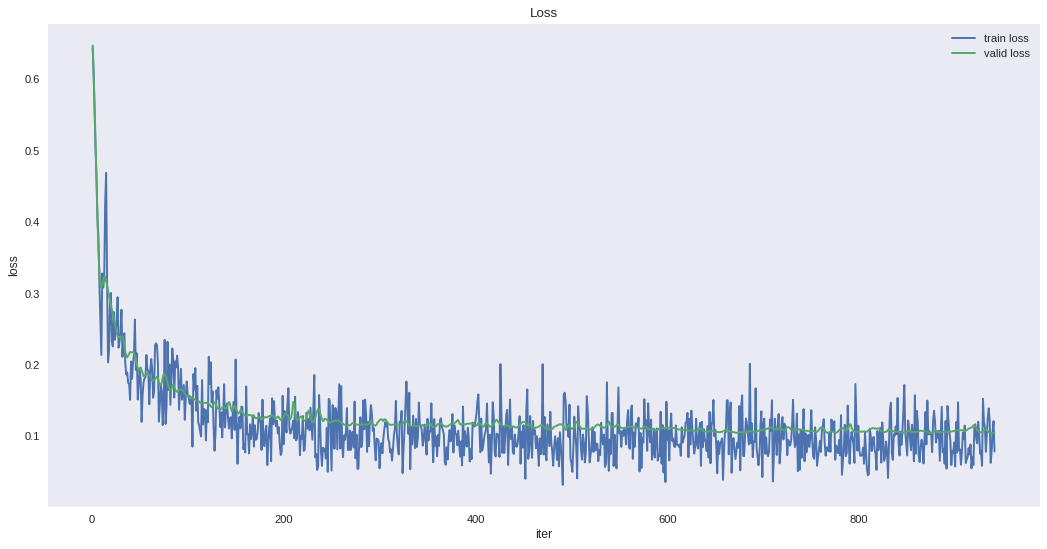

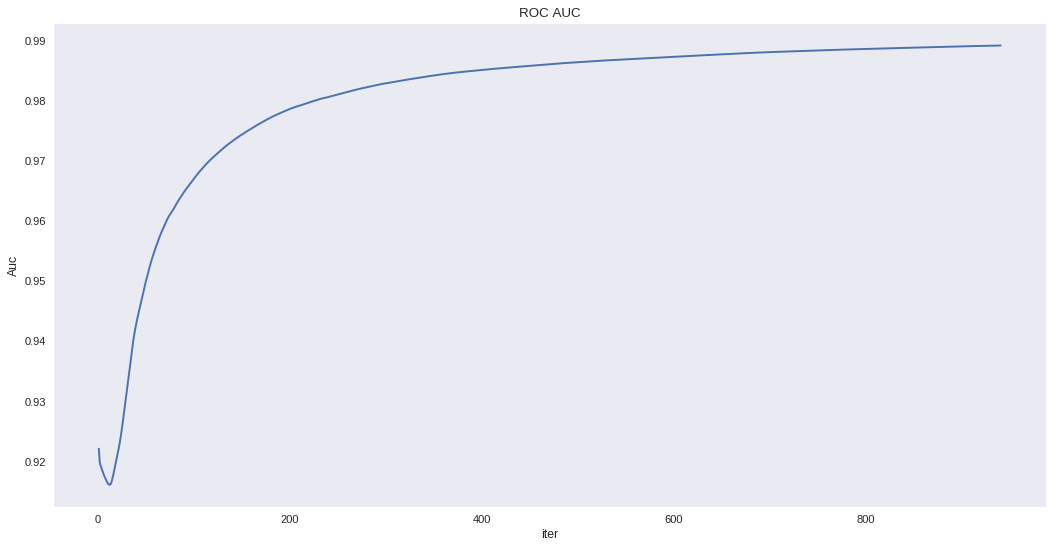

In [39]:
plot_results(iteration0, train_loss0, valid_loss0, valid_roc0)

**Plot Loss & ROC AUC graph for model belonging to sentiment 2**

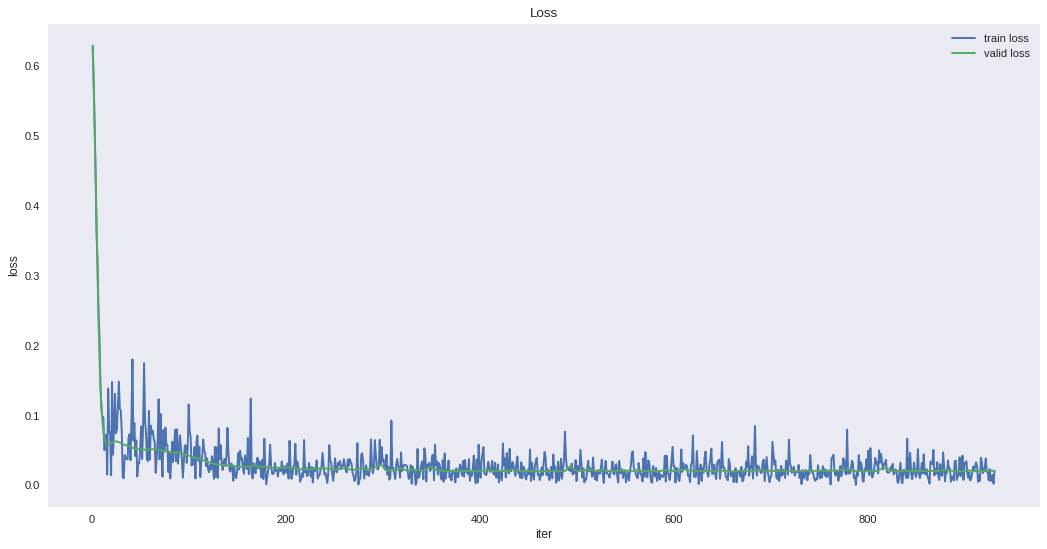

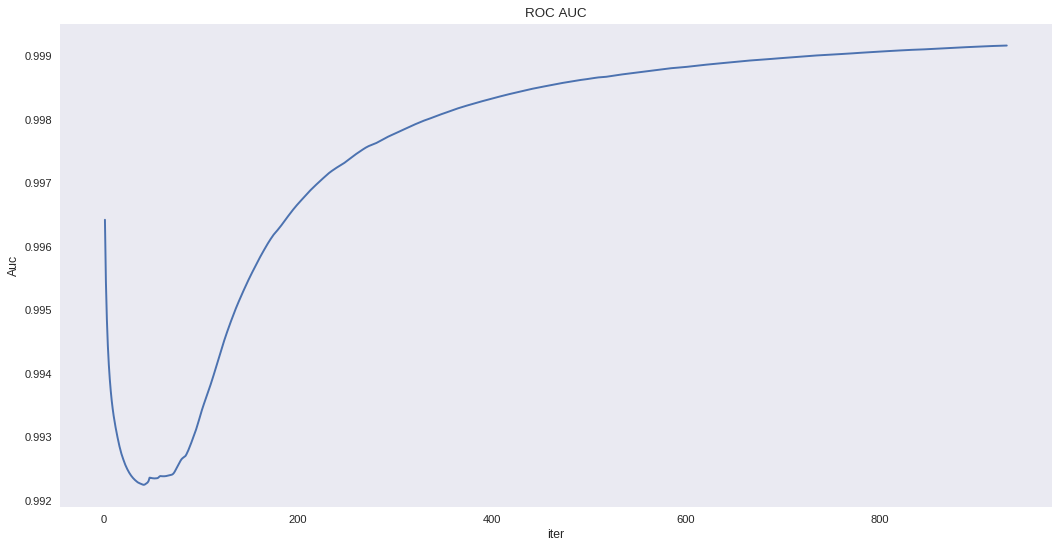

In [40]:
plot_results(iteration1, train_loss1, valid_loss1, valid_roc1)

**Plot Loss & ROC AUC graph for model belonging to sentiment 3**

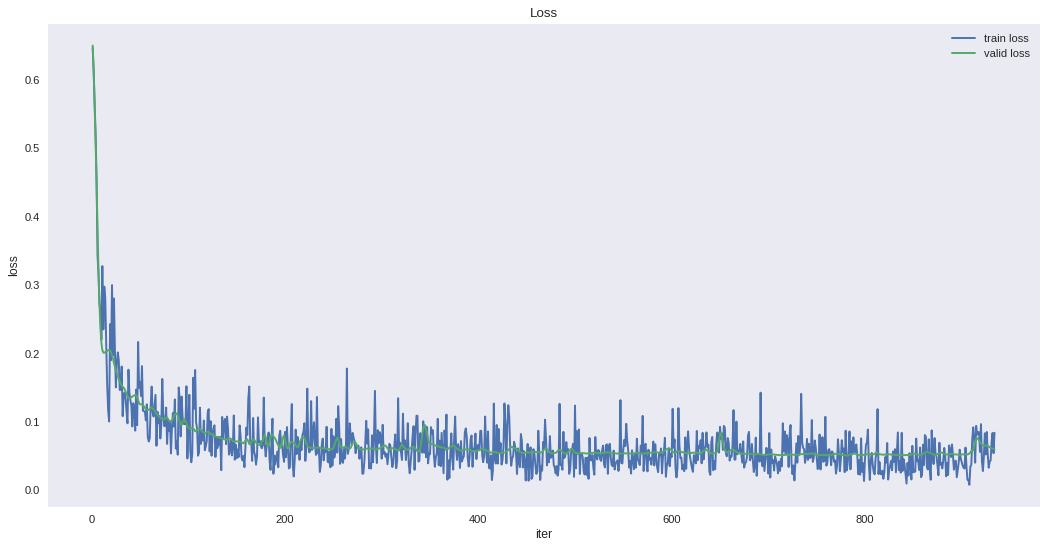

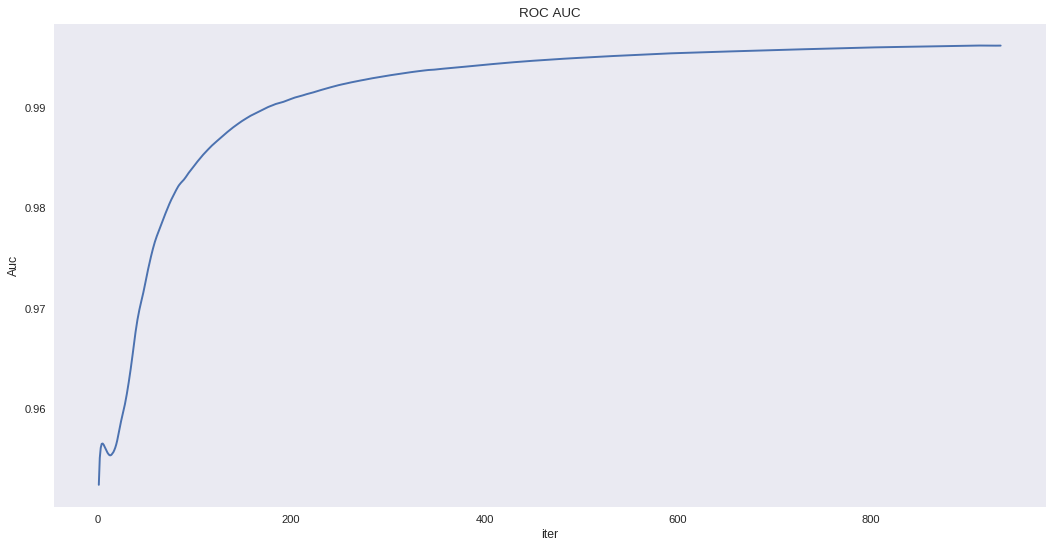

In [41]:
plot_results(iteration2, train_loss2, valid_loss2, valid_roc2)

**Plot Loss & ROC AUC graph for model belonging to sentiment 4**

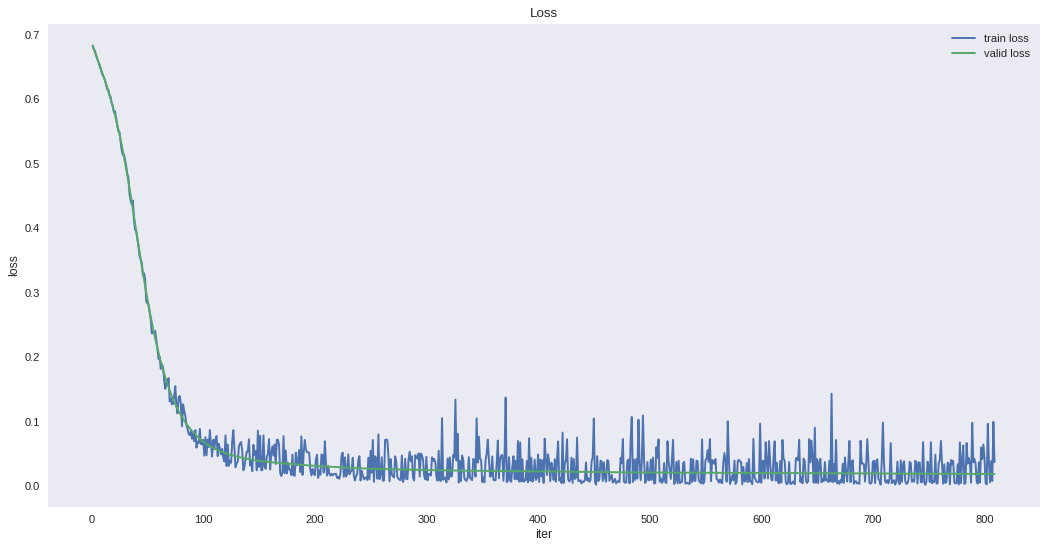

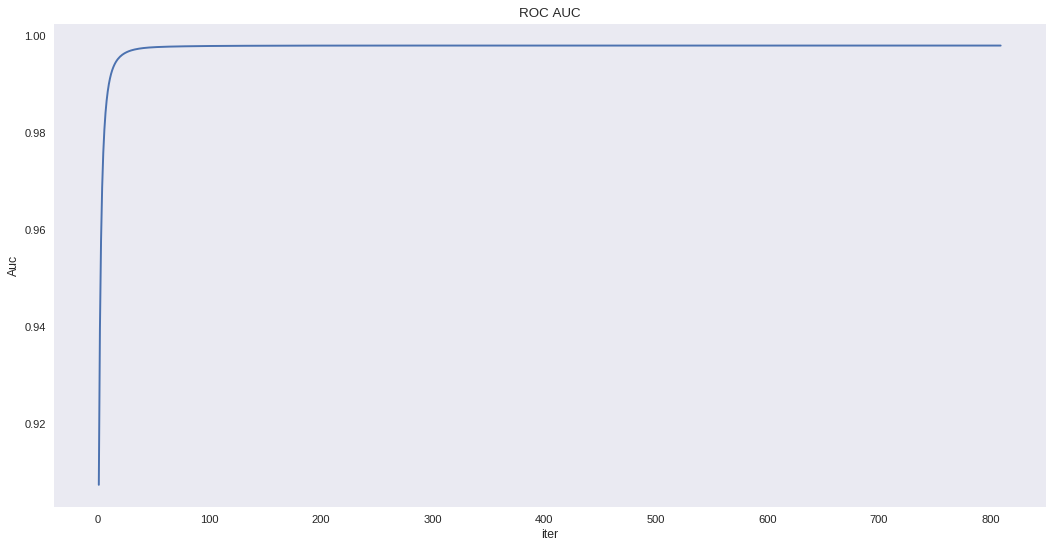

In [42]:
plot_results(iteration3, train_loss3, valid_loss3, valid_roc3)

**Plot Loss & ROC AUC graph for model belonging to sentiment 5**

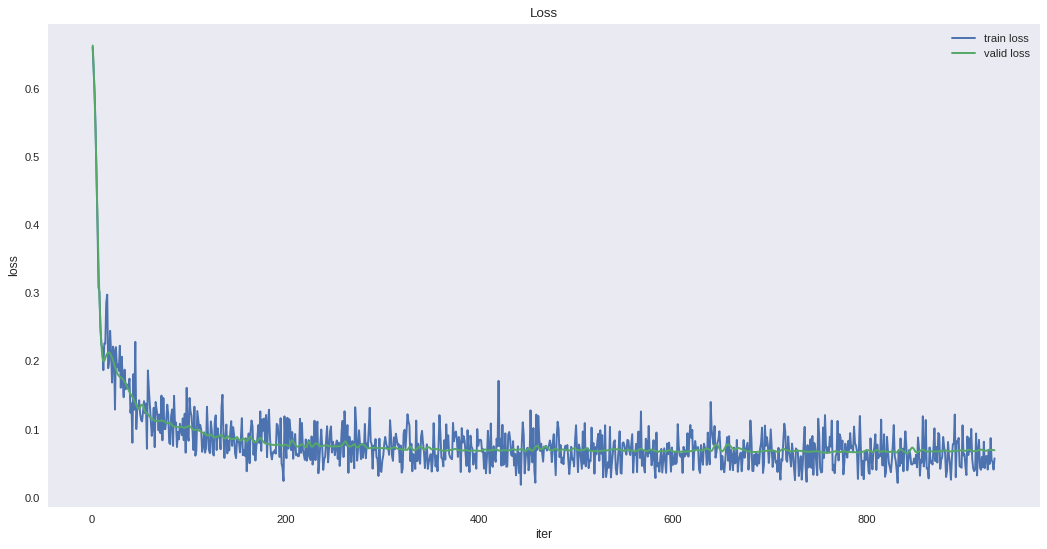

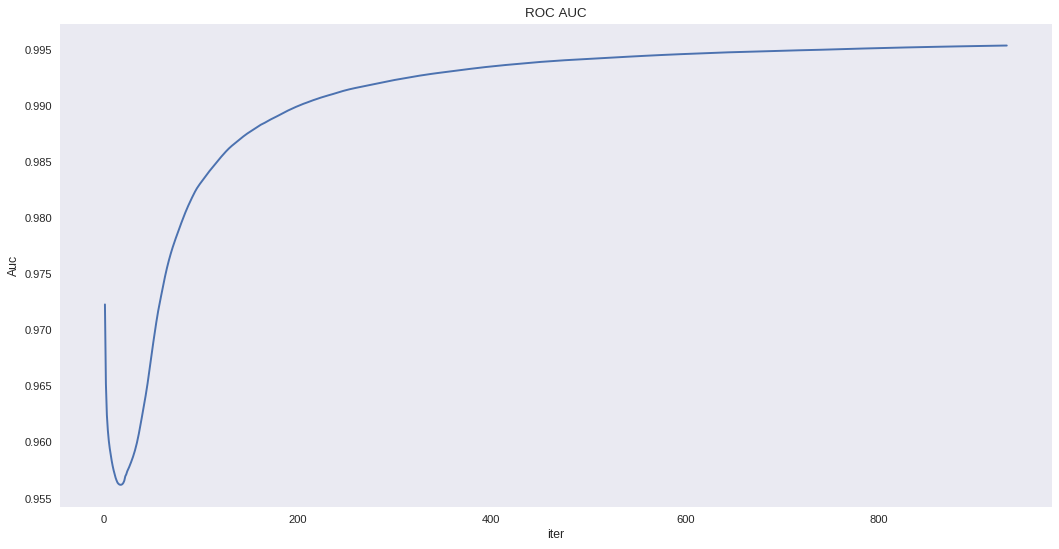

In [43]:
plot_results(iteration4, train_loss4, valid_loss4, valid_roc4)

**Plot Loss & ROC AUC graph for model belonging to sentiment 6**

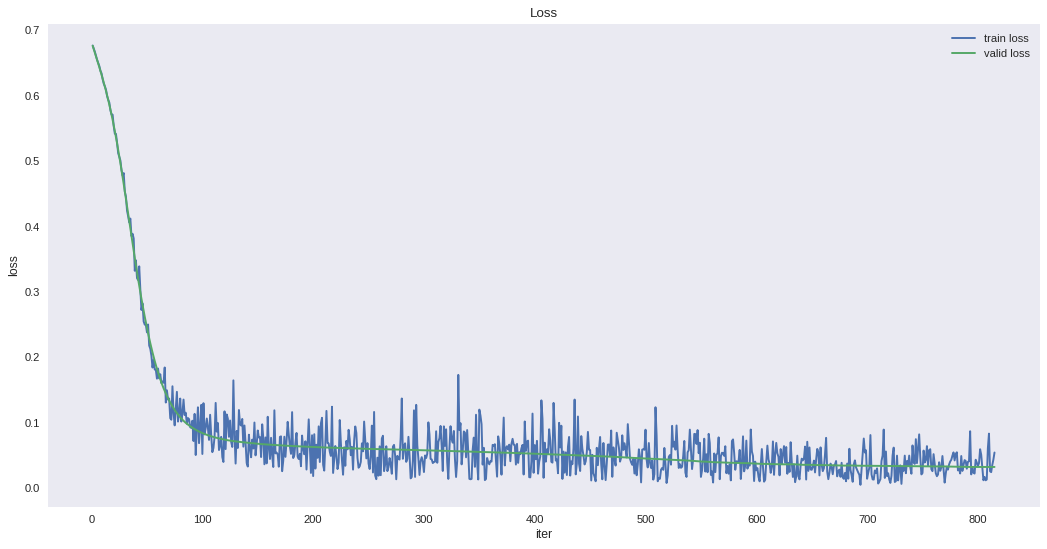

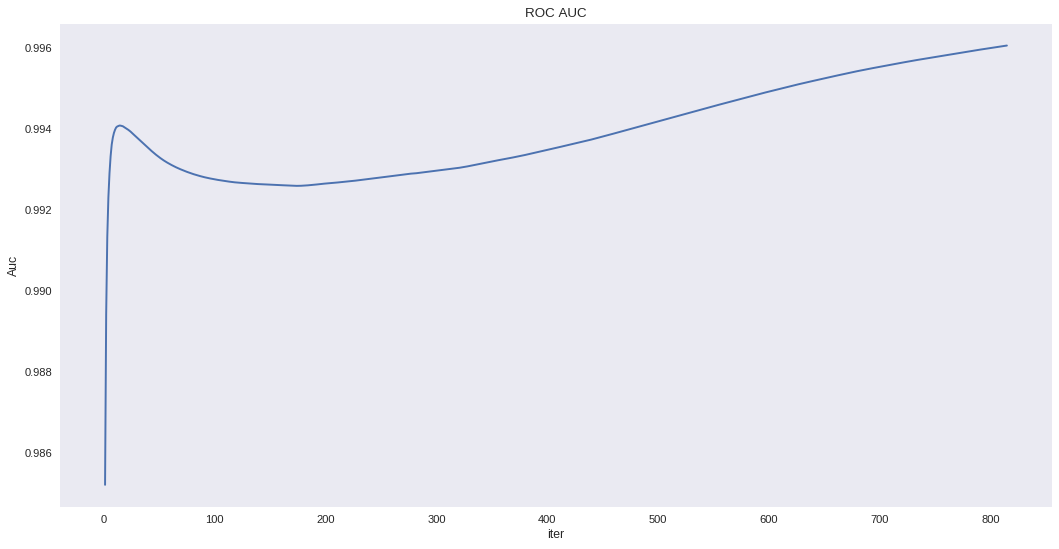

In [44]:
plot_results(iteration5, train_loss5, valid_loss5, valid_roc5)

In [0]:
del(comments_train, sentiments_train, seq_length_train, comments_validation, sentiments_validation, seq_length_validation)

# Compute predictions for 6 different classifiers

### A function to compute predictions for a single classifier

In [0]:
def compute_prediction(saver, sentiment_cls, X, length, keep_prob, logits, best_iteration):

    with tf.Session() as sess:  

        # restore the best model
        model_path = "./"+"my-model"+str(sentiment_cls)+"-"+str(best_iteration)
        saver.restore(sess, model_path)

        # break the test set into k folds other wise kernel will be out of memory
        n = len(test_id)
        k = 40
        step = n//k

        # array to store the prediction
        preds = np.array([])

        # iterate through each fold
        for i in range(k):

            # start and end indices of the fold
            if i != (k-1):
                start = (step*i)
                end = (step*(i+1)) 
            else:
                start = (step*i)
                end = len(test_id)



            # feed dictionary for the fold
            feed_dict_test =  {X:sequence_generator(comments_test[start:end], max_length, size),
                                length:seq_length_test[start:end],
                                keep_prob: 1.0}

            # evaluate predictions of the fold
            fold_preds = logits.eval(session=sess, feed_dict = feed_dict_test)[:,1]
            if i == 0:
                preds  = fold_preds
            else:
                preds = np.append(preds, fold_preds, axis=0)

            print("Computed predictions for fold",i)
          
    return preds

**Compute predictions for six different classifiers**

In [47]:
print("Compute predictions for toxic sentiment:")
preds0 = compute_prediction(saver0, 0, X0, length0, keep_prob0, logits0, best_iteration0)
print("\n")
print("Compute predictions for severe_toxic sentiment:")
preds1 = compute_prediction(saver1, 1, X1, length1, keep_prob1, logits1, best_iteration1)
print("\n")
print("Compute predictions for obscene sentiment:")
preds2 = compute_prediction(saver2, 2, X2, length2, keep_prob2, logits2, best_iteration2)
print("\n")
print("Compute predictions for threat sentiment:")
preds3 = compute_prediction(saver3, 3, X3, length3, keep_prob3, logits3, best_iteration3)
print("\n")
print("Compute predictions for insult sentiment:")
preds4 = compute_prediction(saver4, 4, X4, length4, keep_prob4, logits4, best_iteration4)
print("\n")
print("Compute predictions for identity_hate sentiment:")
preds5 = compute_prediction(saver5, 5, X5, length5, keep_prob5, logits5, best_iteration5)

Compute predictions for toxic sentiment:
INFO:tensorflow:Restoring parameters from ./my-model0-936
Computed predictions for fold 0
Computed predictions for fold 1
Computed predictions for fold 2
Computed predictions for fold 3
Computed predictions for fold 4
Computed predictions for fold 5
Computed predictions for fold 6
Computed predictions for fold 7
Computed predictions for fold 8
Computed predictions for fold 9
Computed predictions for fold 10
Computed predictions for fold 11
Computed predictions for fold 12
Computed predictions for fold 13
Computed predictions for fold 14
Computed predictions for fold 15
Computed predictions for fold 16
Computed predictions for fold 17
Computed predictions for fold 18
Computed predictions for fold 19
Computed predictions for fold 20
Computed predictions for fold 21
Computed predictions for fold 22
Computed predictions for fold 23
Computed predictions for fold 24
Computed predictions for fold 25
Computed predictions for fold 26
Computed predictions

# Create and Save submission file

**Create a submission csv file**

In [0]:
del(model, comments_test, seq_length_test)
# save the submission csv file
submission_path = "./submission.csv"
columns = ["id","toxic","severe_toxic","obscene","threat","insult","identity_hate"]
submission = pd.DataFrame({"id":test_id, "toxic": preds0, "severe_toxic":preds1,"obscene":preds2,"threat":preds3,"insult":preds4,"identity_hate":preds5})
submission.to_csv(submission_path, header = True, index=False)

**Save the csv file in google drive**

In [0]:
# Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Create & upload a text file.
uploaded = drive.CreateFile({'title': 'submission.csv', 'parents':[{u'id': file_id_data["download_folder2_id"]}]})
uploaded.SetContentFile("submission.csv")
uploaded.Upload()